In [12]:
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import pandas as pd
import os
import scipy.stats as stats            # Basic package for basic univariate regressions
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

# Data Analysis

Data will be loaded from the CSV files created in the 'Study-Data' file.

This program runs Ordinary Least Squares regressions for every possible intermarket relationship between the assets and currencies selected, in the periods for both pre and post covid. These regressions are based on daily price changes. Then, it returns those with significant values. This way, relationship changes will be easily identifiable.

# Load, Organize, and Clean Data

In [2]:
os.chdir('Covid-Study-Data')

#Read CSV files from the file created in 'Study-Data'
pre = pd.read_csv('Precovid.csv',index_col = [0],parse_dates = True)
post = pd.read_csv('Postcovid.csv',index_col = [0],parse_dates = True)
meta = pd.read_csv('data.csv',index_col = [0],parse_dates = True)

#Rename columns for US Treasuries
meta.rename(columns = {'DGS10':'US10Y','DGS2':'US2Y','DGS30':'US30Y'}, inplace = True)
pre.rename(columns = {'DGS10':'US10Y','DGS2':'US2Y','DGS30':'US30Y'}, inplace = True)
post.rename(columns = {'DGS10':'US10Y','DGS2':'US2Y','DGS30':'US30Y'}, inplace = True)

#Create new dataframes for daily percentage changes
prepct = pre.pct_change()[1:].astype(float)
postpct = post.pct_change()[1:].astype(float)
metapct = meta.pct_change()[1:].astype(float)

#Replace infinite percentage change and nan values with 0
postpct.replace([np.inf, -np.inf], 0,inplace=True)
prepct.replace([np.inf, -np.inf], 0,inplace=True)
metapct.replace([np.inf, -np.inf], 0,inplace=True)
postpct.replace([np.nan],0,inplace=True)
prepct.replace([np.nan],0,inplace=True)
metapct.replace([np.nan],0,inplace=True)

#x dataframes contain independent variables, y dataframes contain dependent variables
#xmeta is a dataframe containing daily percentage changes for all assets considered dependent variables
xmeta = metapct[['US2Y','US10Y','US30Y','DFII10','DFII30','S&P500','DJIA','NASDAQ','GOLD','BTCUSD']]
xmeta = xmeta[1:]
ymeta = metapct[['DXY','EURUSD','GBPUSD','CADUSD','CHFUSD','JPYUSD','AUDUSD','NZDUSD','NOKUSD','SEKUSD','MXNUSD','RUBUSD',
                'BRLUSD','CNYUSD','BTCUSD','GOLD']][1:]

#'pre' and 'post' correspond to the pre-COVID and post-COVID periods
xpost = postpct[['US2Y','US10Y','US30Y','DFII10','DFII30','S&P500','DJIA','NASDAQ','GOLD','BTCUSD']]
xpost = xpost[1:]
xpre = prepct[['US2Y','US10Y','US30Y','DFII10','DFII30','S&P500','DJIA','NASDAQ','GOLD','BTCUSD']]
xpre = xpre[1:]
ypre = prepct[['DXY','EURUSD','GBPUSD','CADUSD','CHFUSD','JPYUSD','AUDUSD','NZDUSD','NOKUSD','SEKUSD','MXNUSD','RUBUSD',
                'BRLUSD','CNYUSD','BTCUSD','GOLD']][1:]
ypost = postpct[['DXY','EURUSD','GBPUSD','CADUSD','CHFUSD','JPYUSD','AUDUSD','NZDUSD','NOKUSD','SEKUSD','MXNUSD','RUBUSD',
                'BRLUSD','CNYUSD','BTCUSD','GOLD']][1:]

Once data has is cleaned and organized in dataframes, we'll create a list of the p-values returned by OLS regressions and their corresponding assets. Then we'll sort the list by p-values. 

In [3]:
pvalues = []

#run a for loop to run OLS regressions between every x variable and every y variable in the post-covid period
#if the p-value for the regression is significant, the relationship will be appended to the pvalues list
for x in xpost.keys():
    for y in ypost.keys():
        if x != y:
            b = xpost[x]
            b = sm.add_constant(b)
            results = sm.OLS(ypost[y],b).fit()
            if results.f_pvalue < 0.05:
                pvalues.append([[x,y],results.f_pvalue,results.params[1]])
                
#A new loop runs OLS regressions for the relationships found in the pvalues list, but now for the pre-covid period
for item in pvalues:
    b = xpre[item[0][0]]
    b = sm.add_constant(b)
    model = sm.OLS(ypre[item[0][1]],b)
    results = model.fit()
    item.append([results.f_pvalue,results.params[1]])
    
#the list is sorted by p-values, each element contains the pvalue, correlation coefficient, and the names of the assets
sorted_d = sorted((value1,value2,value3,key) for (key,value1,value2,value3) in pvalues)

Display Rolling 20 Day correlations for the relationships found in the list of significant p-values.

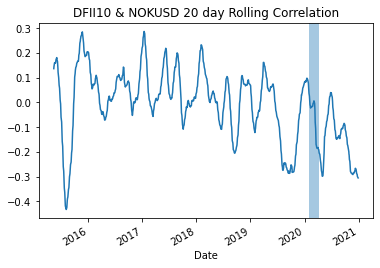

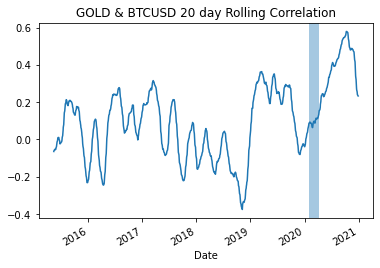

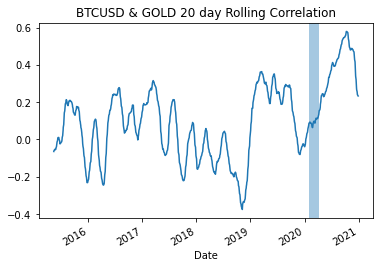

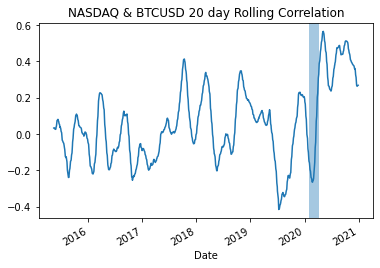

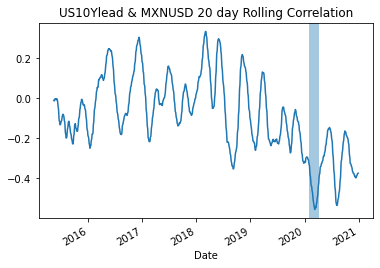

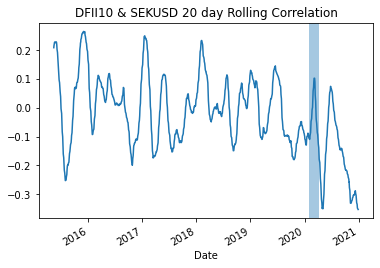

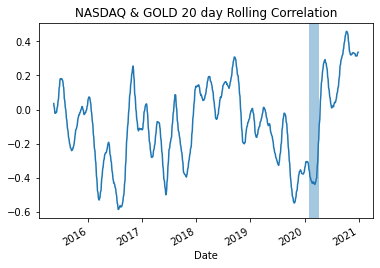

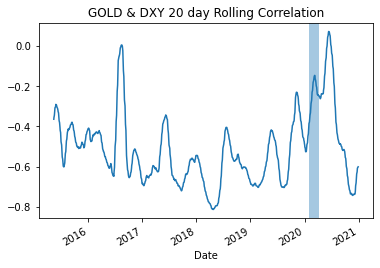

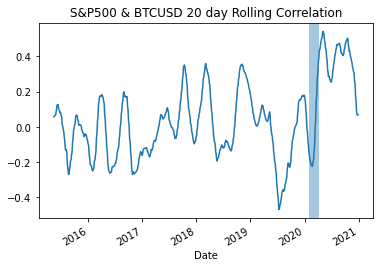

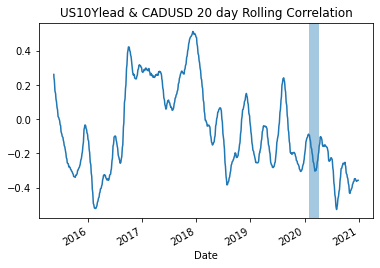

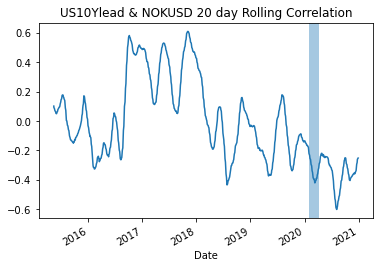

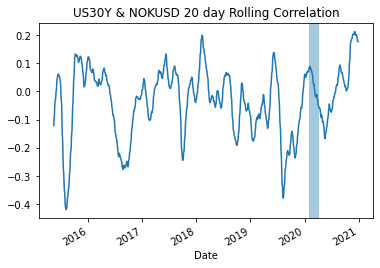

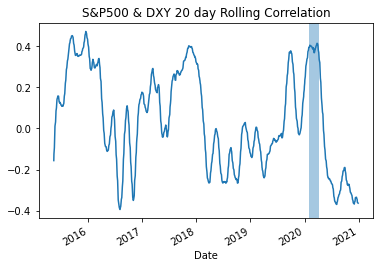

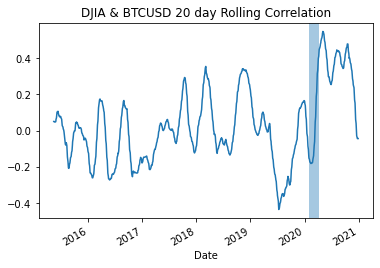

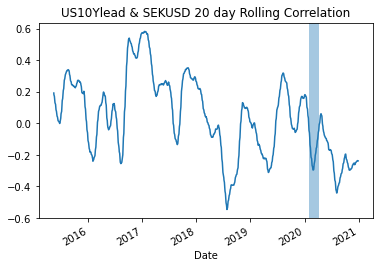

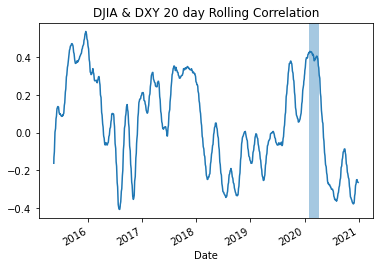

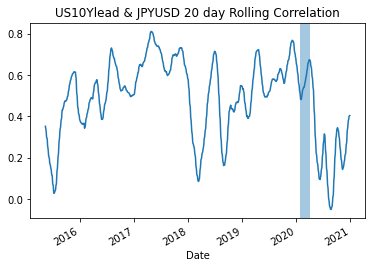

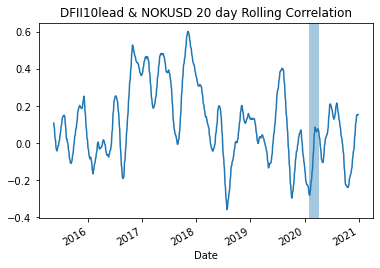

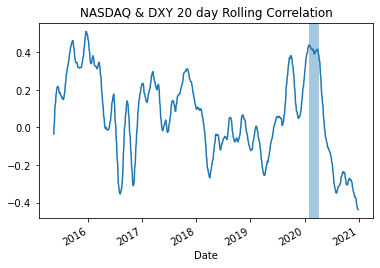

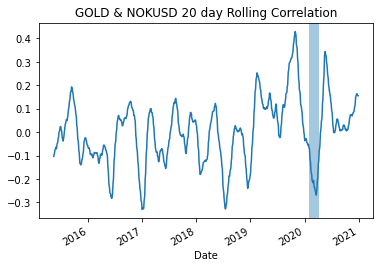

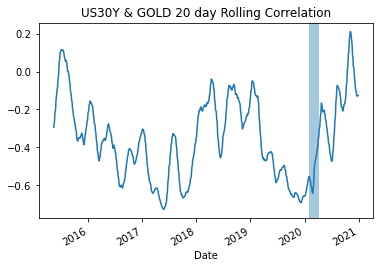

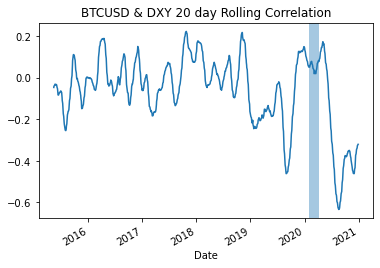

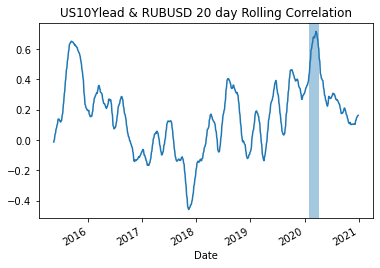

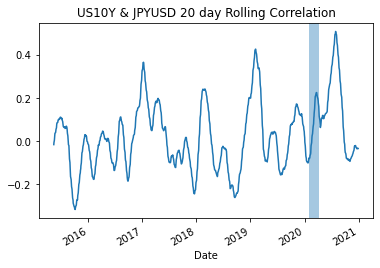

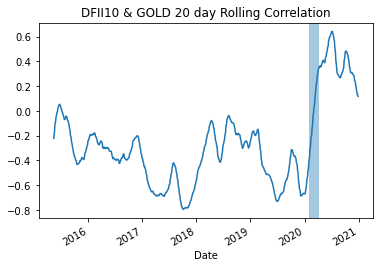

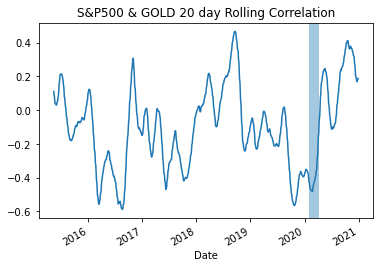

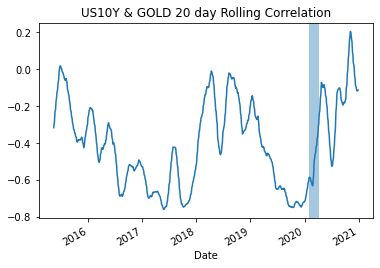

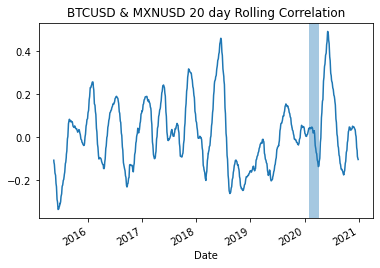

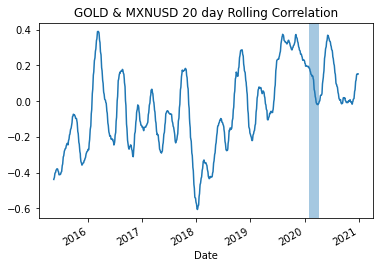

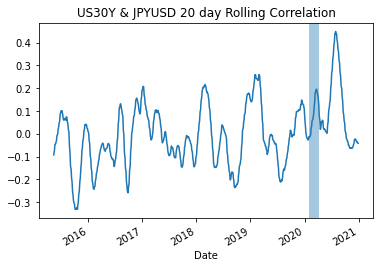

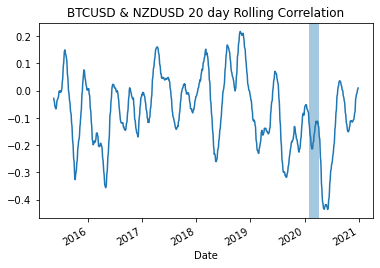

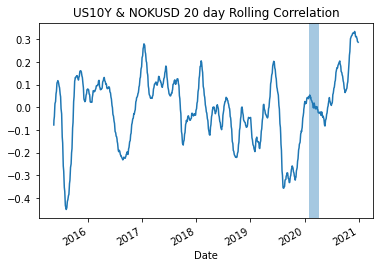

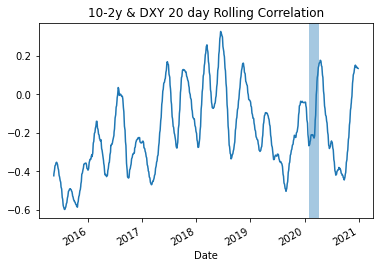

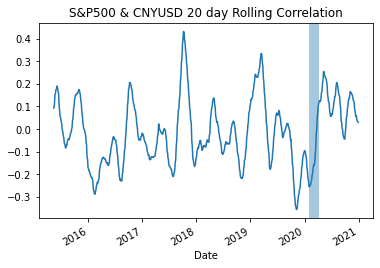

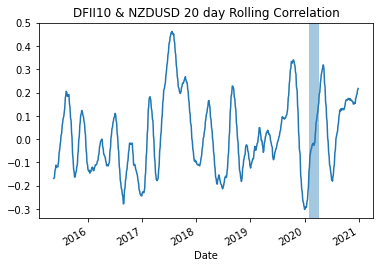

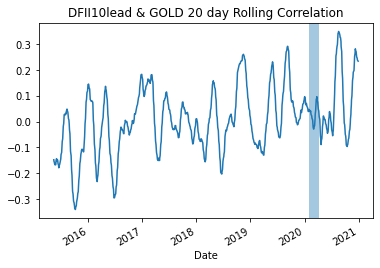

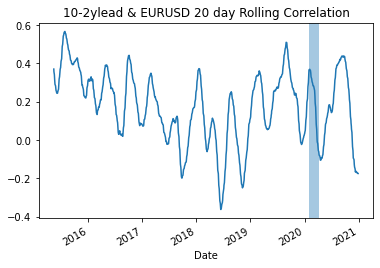

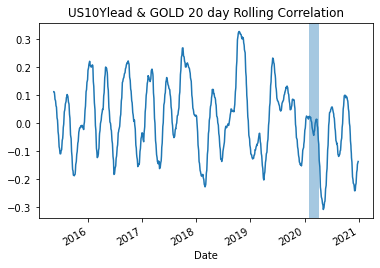

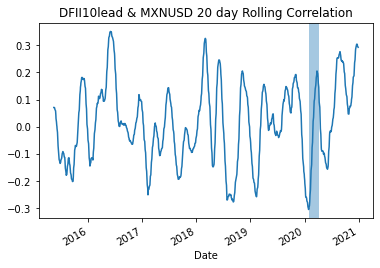

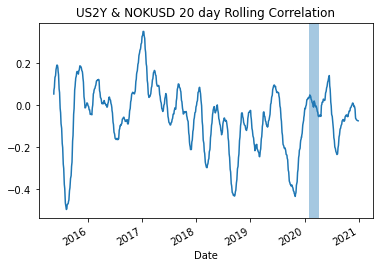

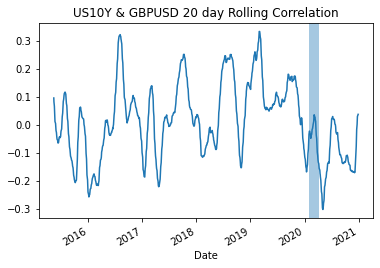

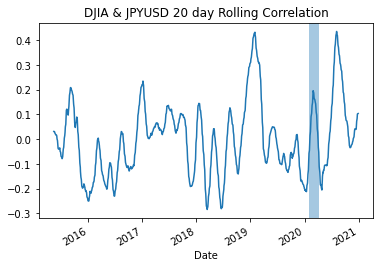

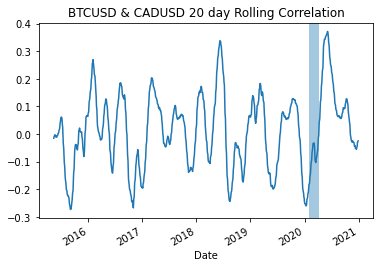

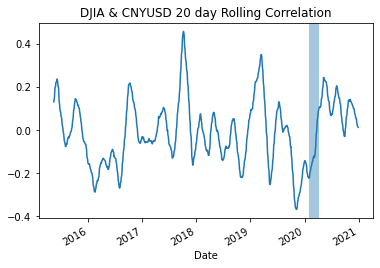

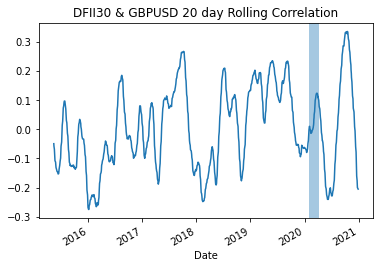

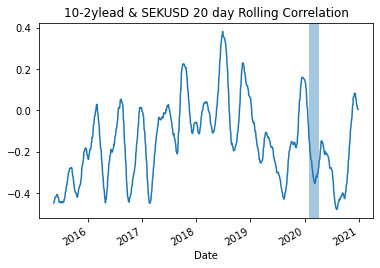

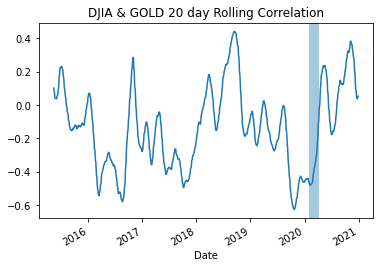

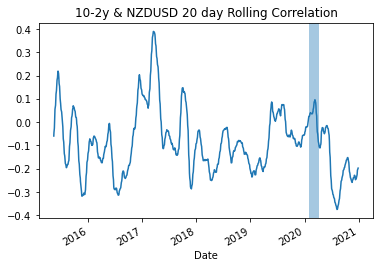

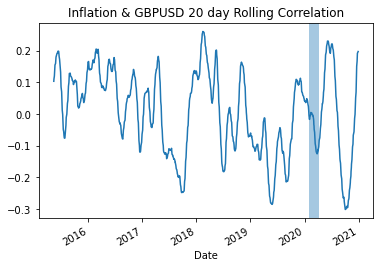

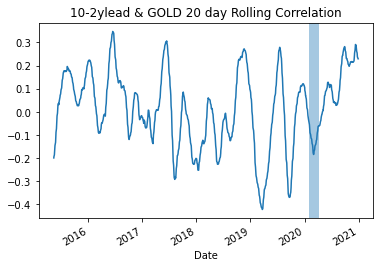

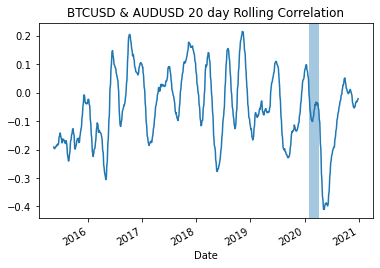

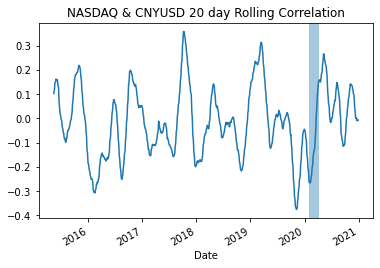

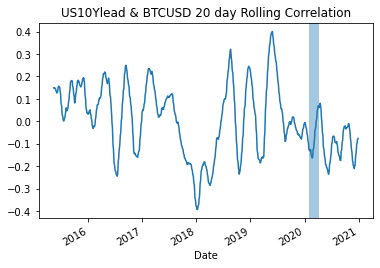

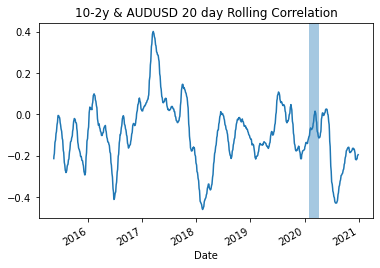

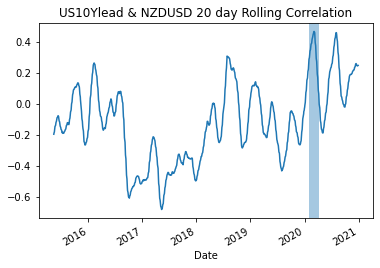

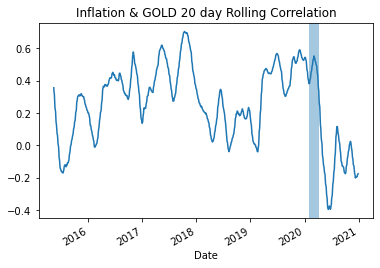

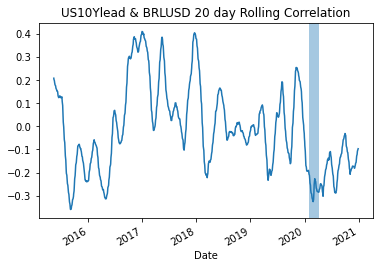

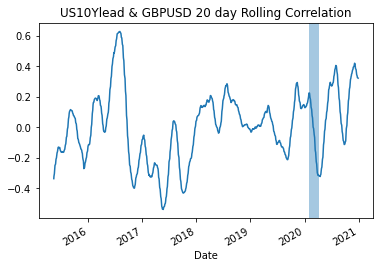

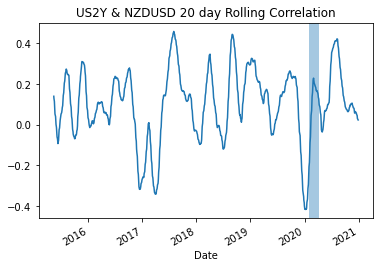

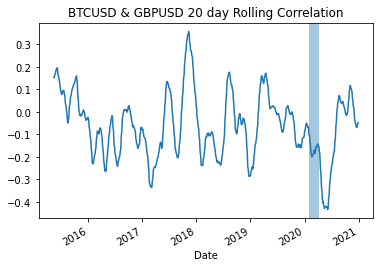

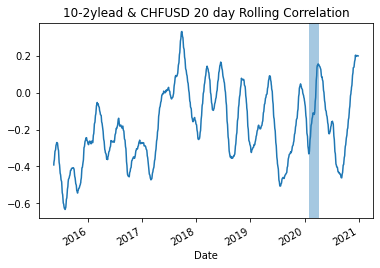

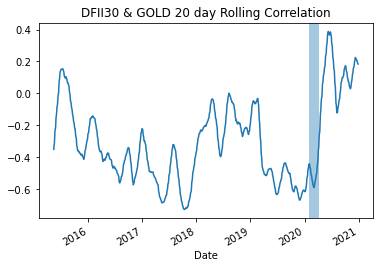

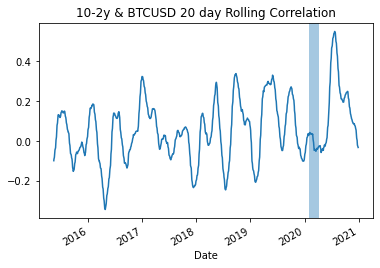

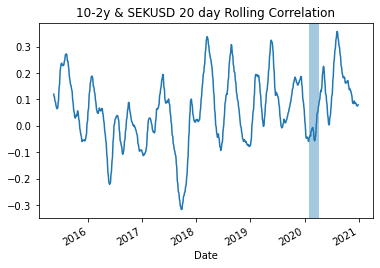

In [4]:
for item in sorted_d:   
    corr = xmeta[item[3][0]].rolling(20).corr(ymeta[item[3][1]])
    corr = corr.rolling(window = 40).mean()
    corr.plot()
    plt.axvline('2020-03-02',linewidth=10,alpha=0.4)
    plt.title(f'{item[3][0]} & {item[3][1]} 20 day Rolling Correlation',fontsize=12)
    plt.show()

In [6]:
#Create a similar list as the 'pvalues' list. This time, we will start by running an OLS regression for every
#possible relationship between x and y variables in the pre-covid period.
#This is necessary to identify relationships that were significant in the pre-covid period but no longer in the post-covid period

pvaluespre = []
for x in xpre.keys():
    for y in ypre.keys():
        if x != y:
            b = xpre[x]
            b = sm.add_constant(b)
            results = sm.OLS(ypre[y],b).fit()
            if results.f_pvalue < 0.05:
                pvaluespre.append([[x,y],results.f_pvalue,results.params[1]])
for item in pvaluespre:
    b = xpost[item[0][0]]
    b = sm.add_constant(b)
    model = sm.OLS(ypost[item[0][1]],b)
    results = model.fit()
    item.append([results.f_pvalue,results.params[1]])
pvaluespre2 = [item for item in pvaluespre if item[3][0] >0.05]
sorted_pre = sorted((value1,value2,value3,key) for (key,value1,value2,value3) in pvaluespre2)

Make plots of the OLS regressions for all relationships with a significant p-value in either period.

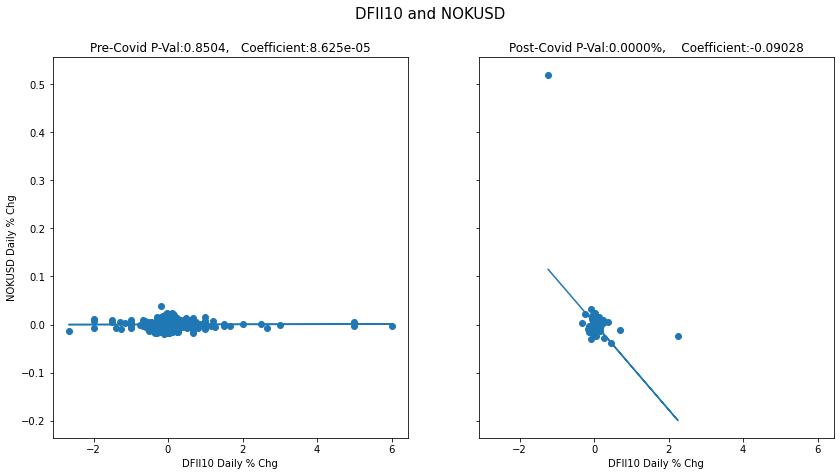

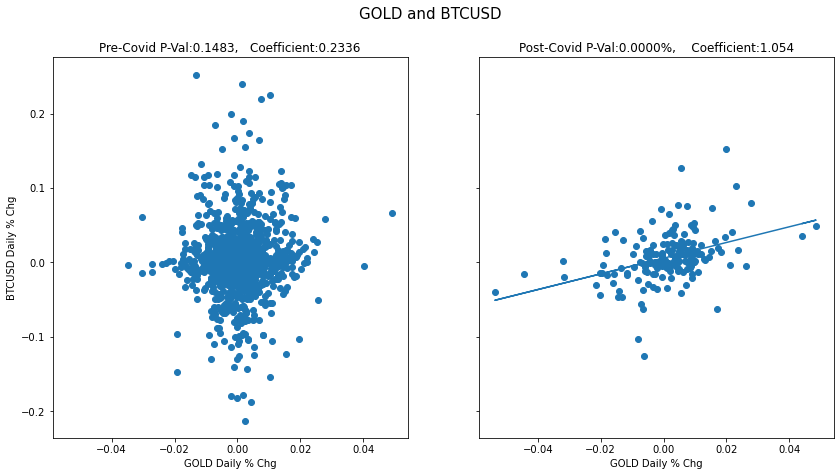

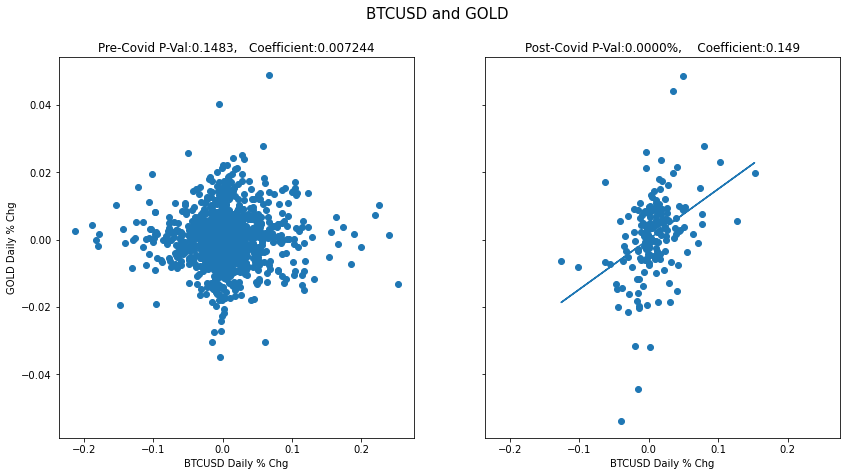

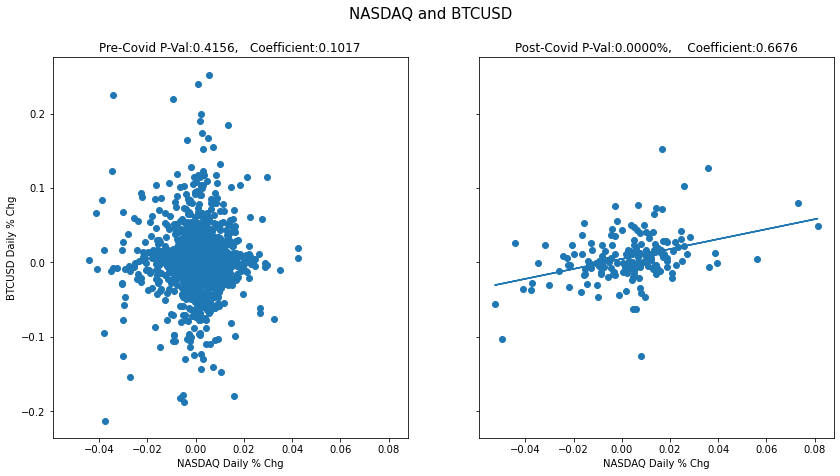

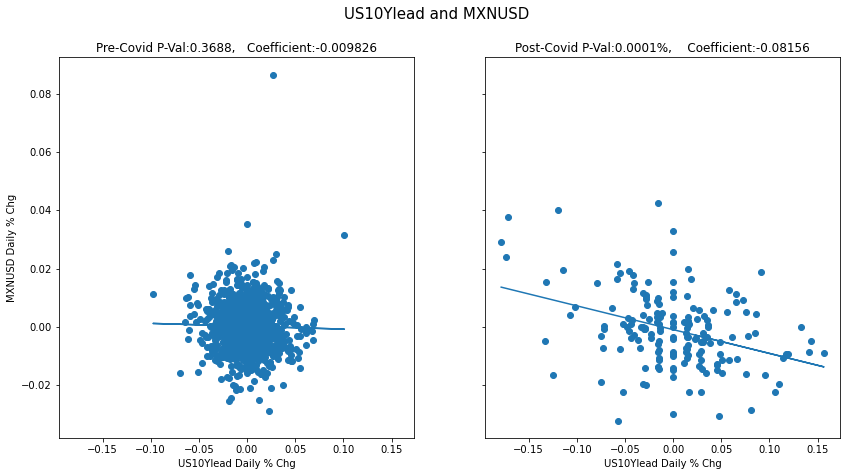

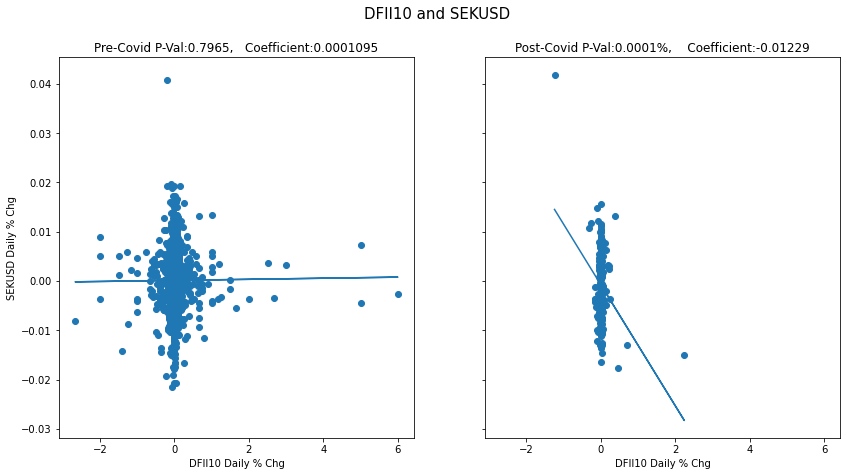

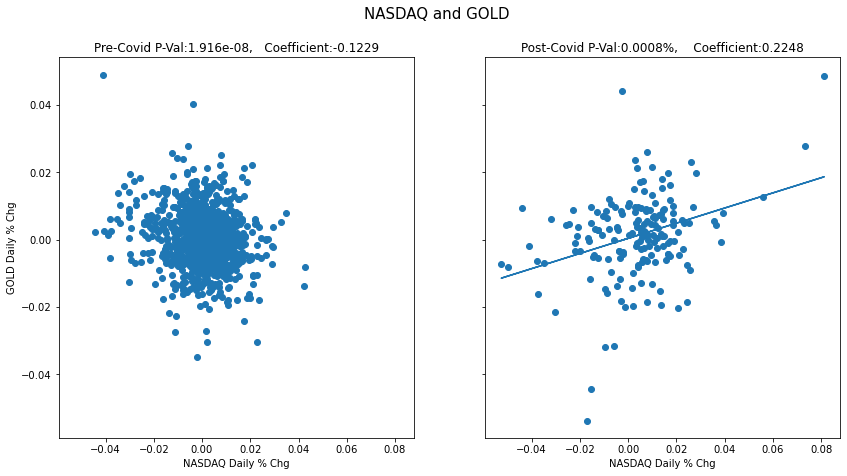

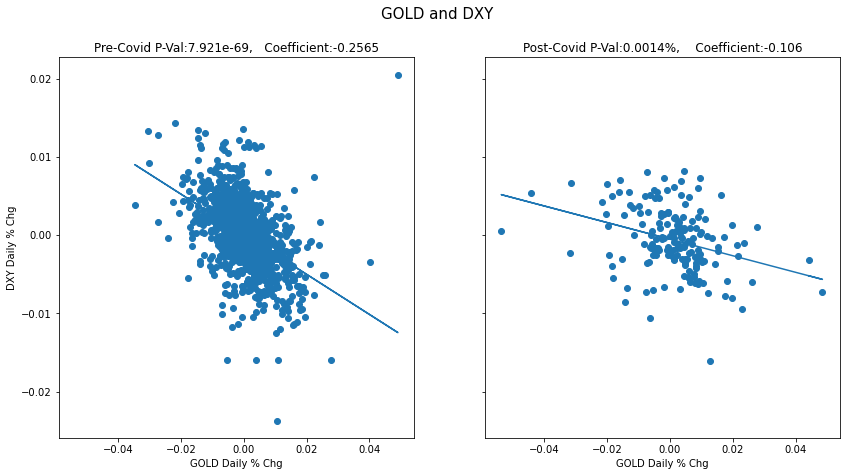

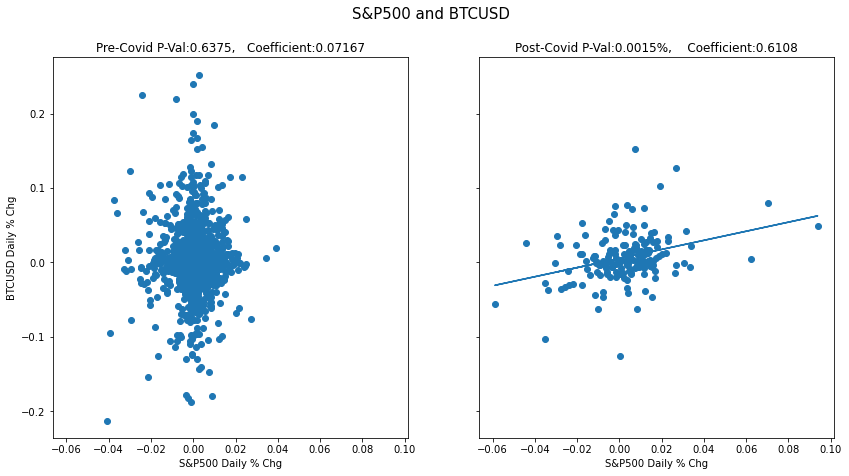

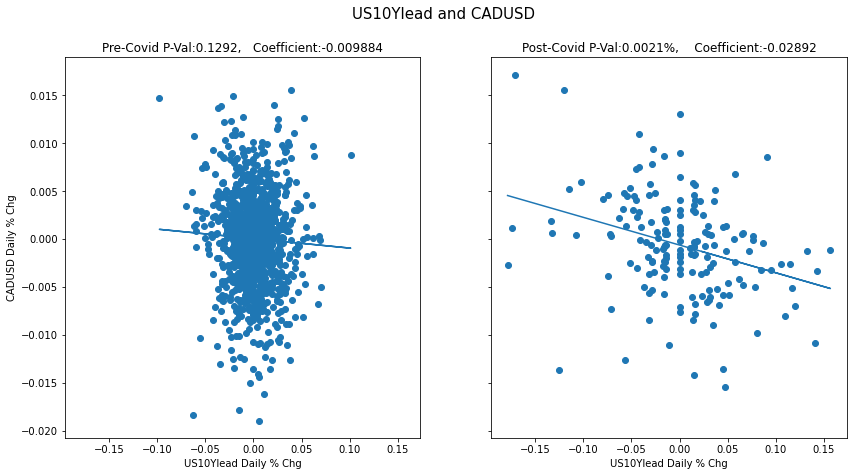

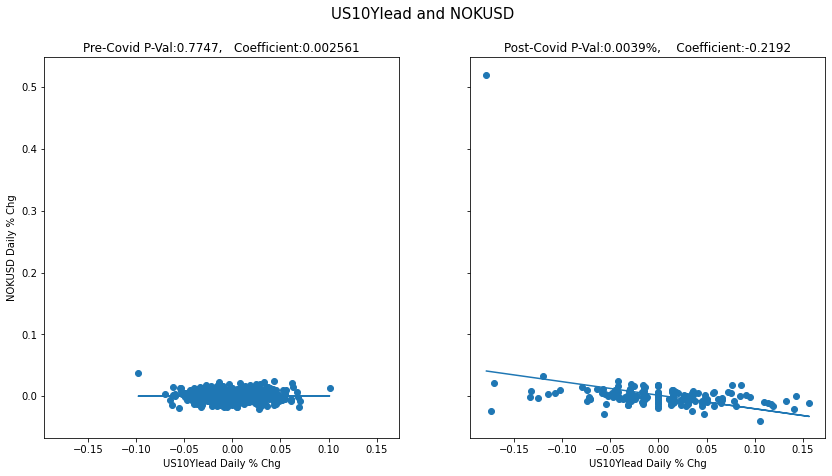

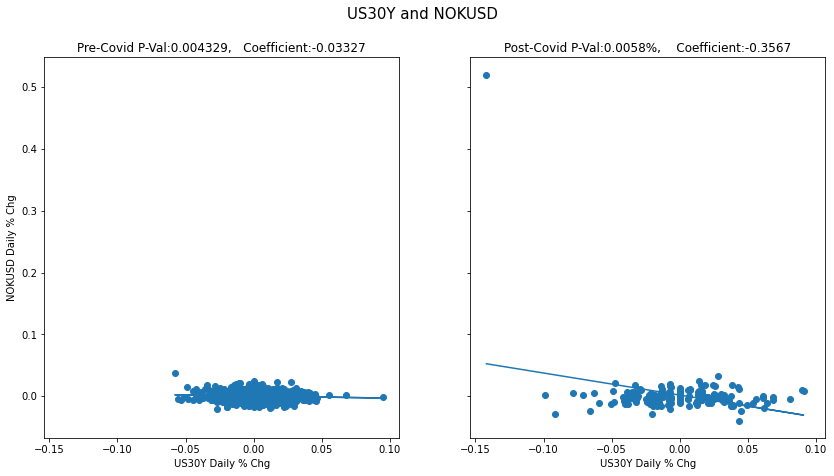

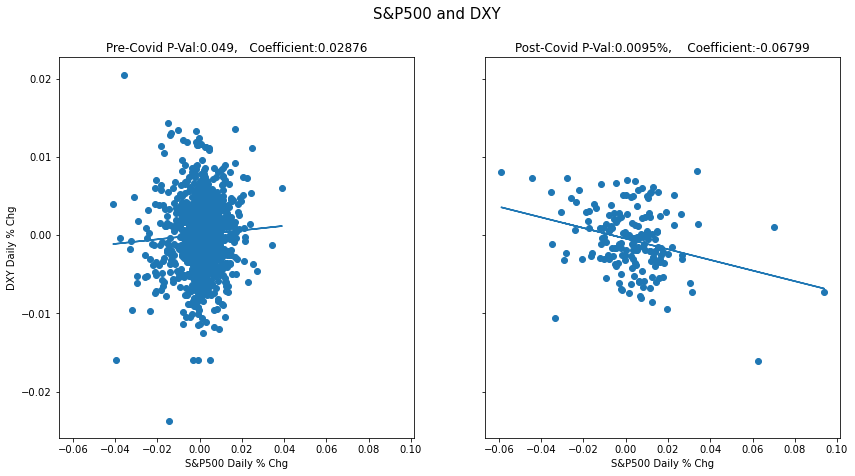

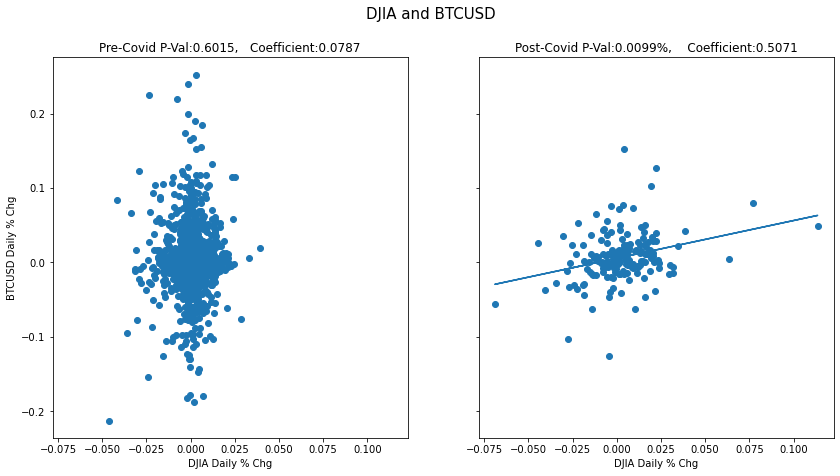

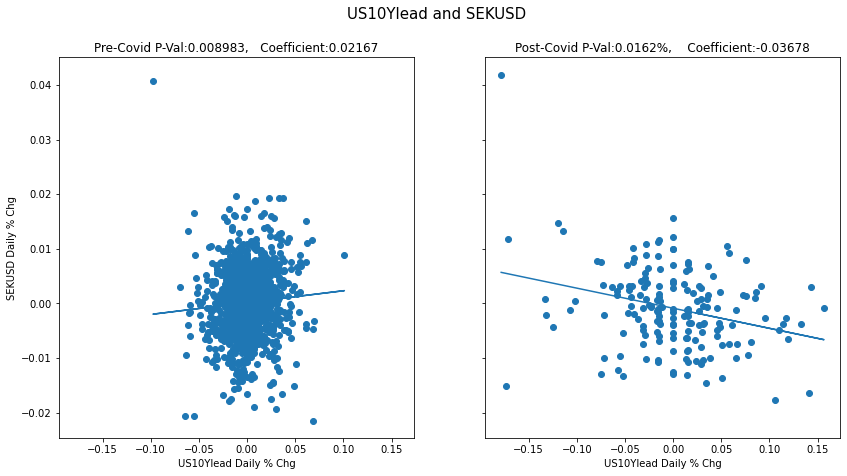

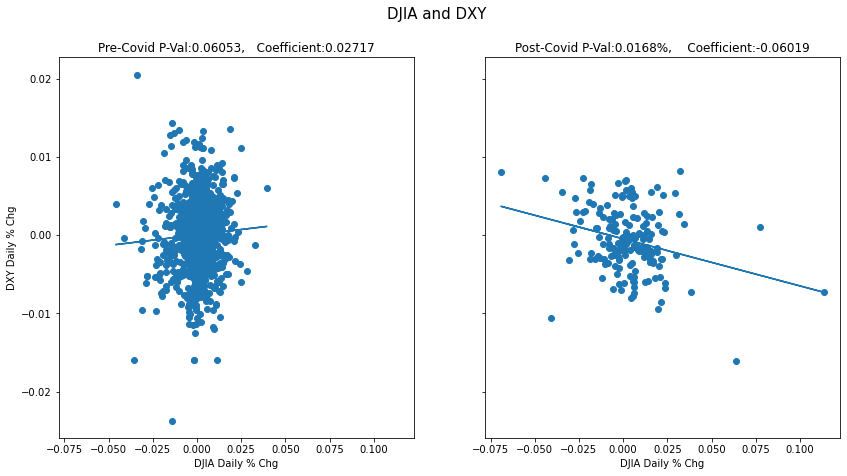

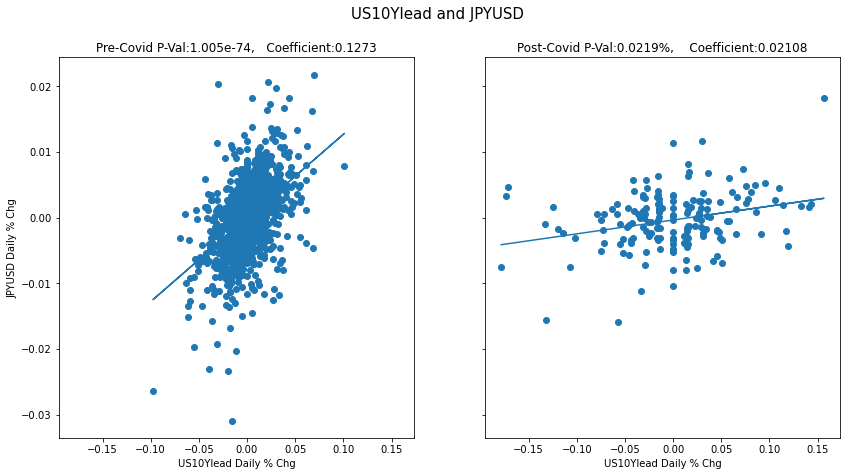

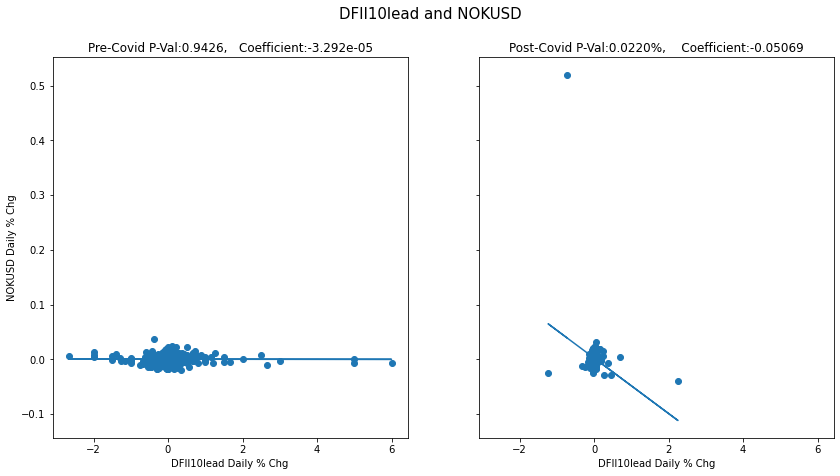

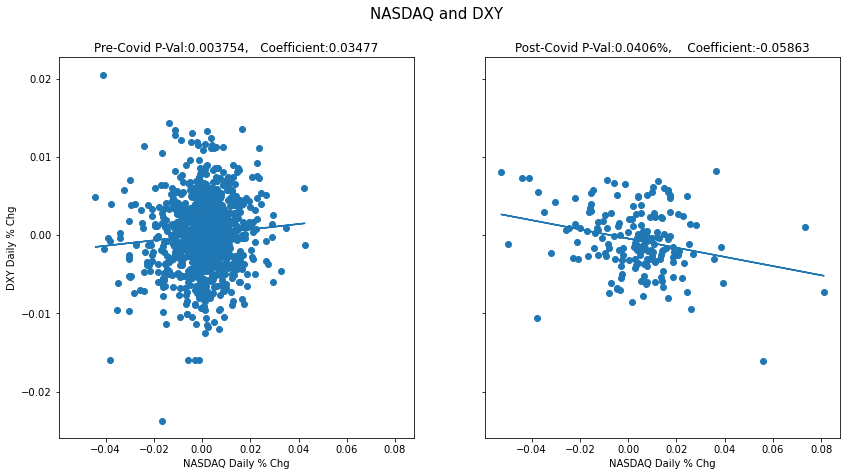

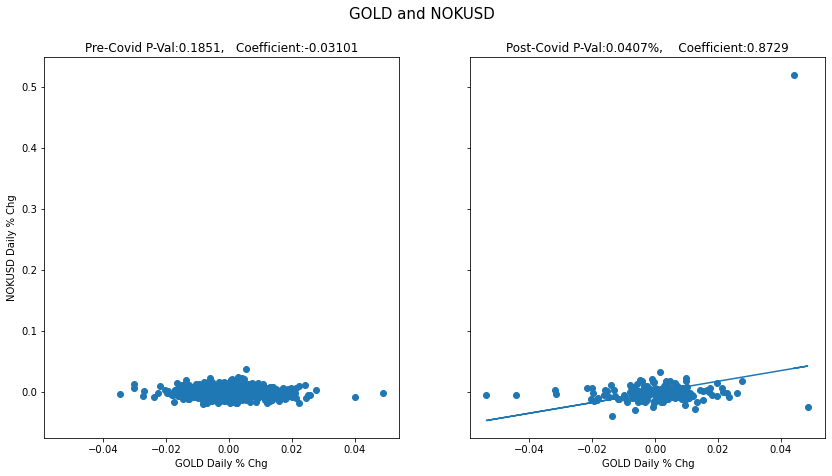

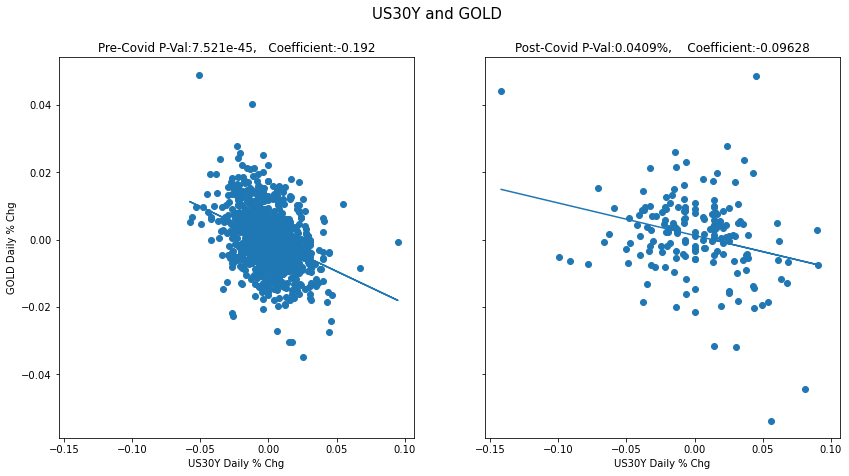

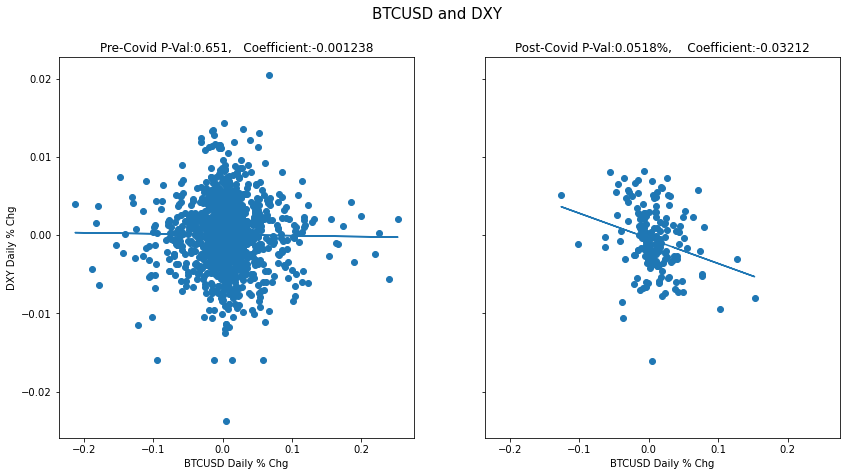

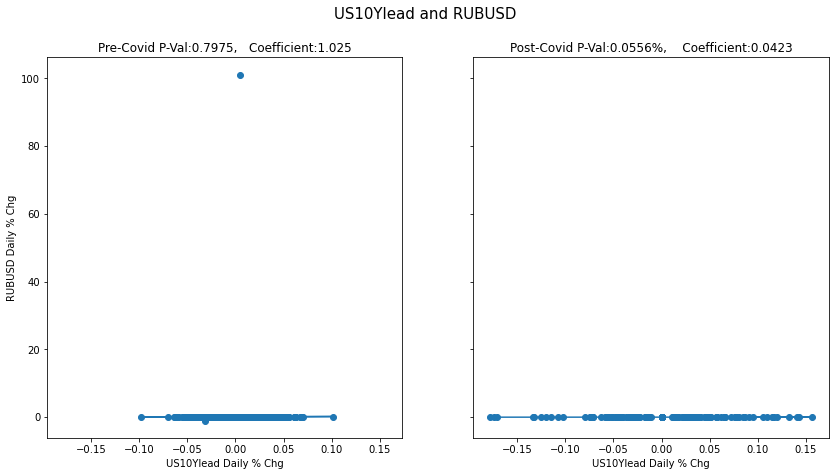

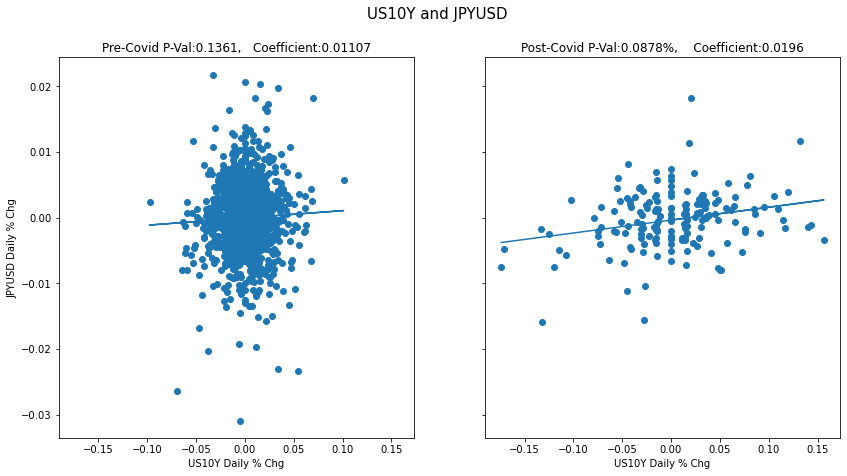

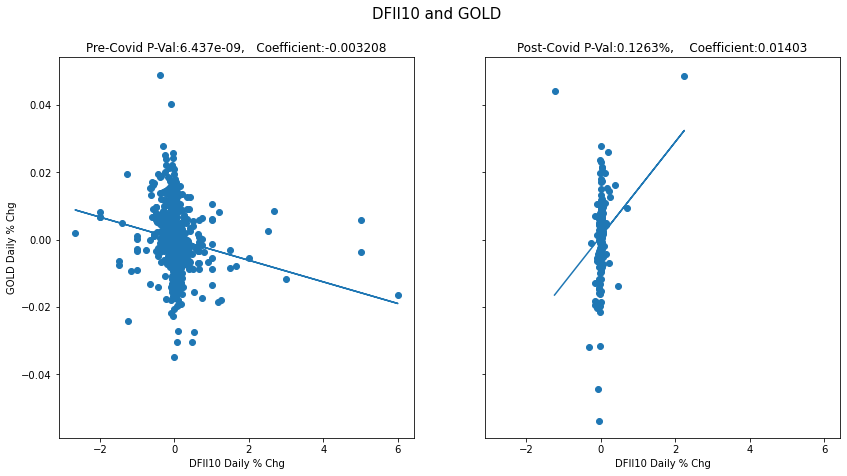

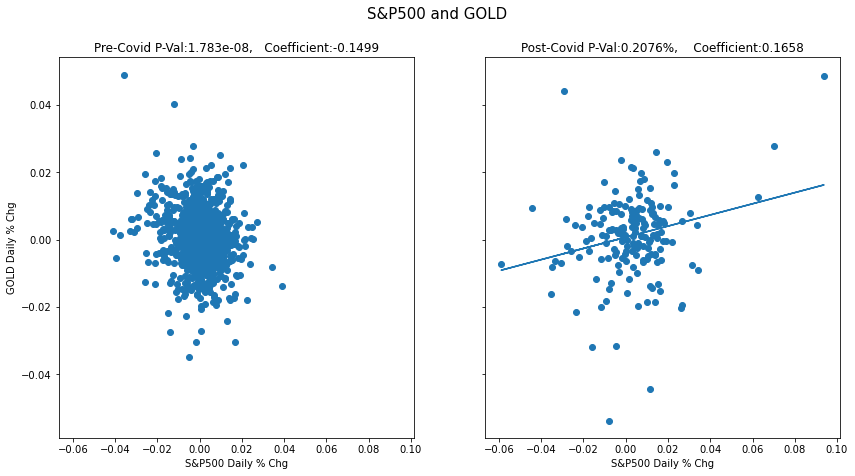

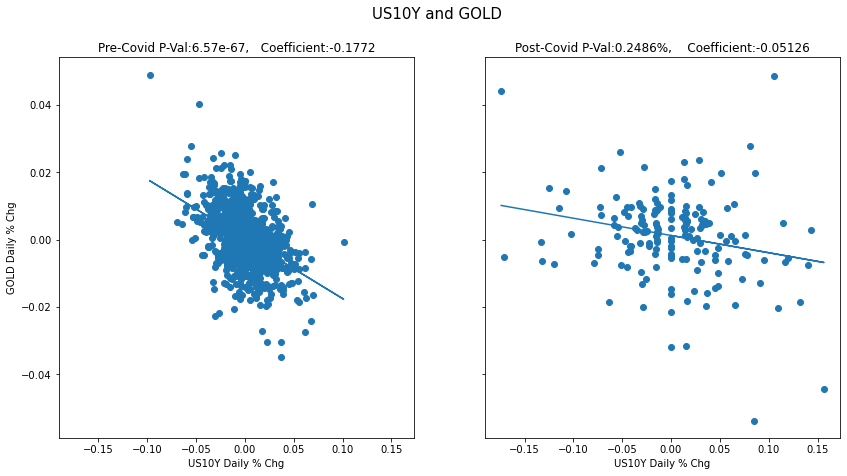

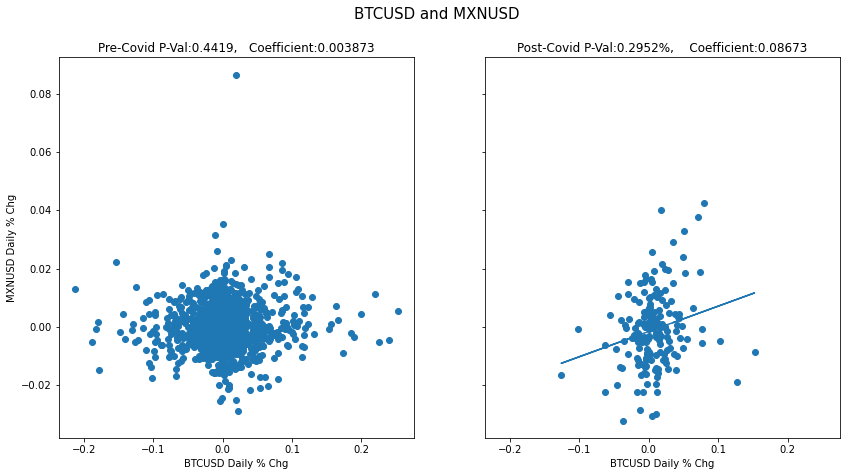

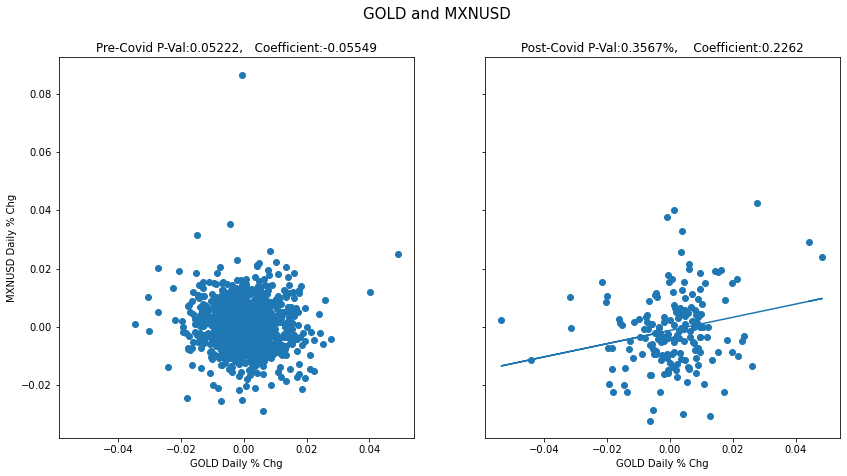

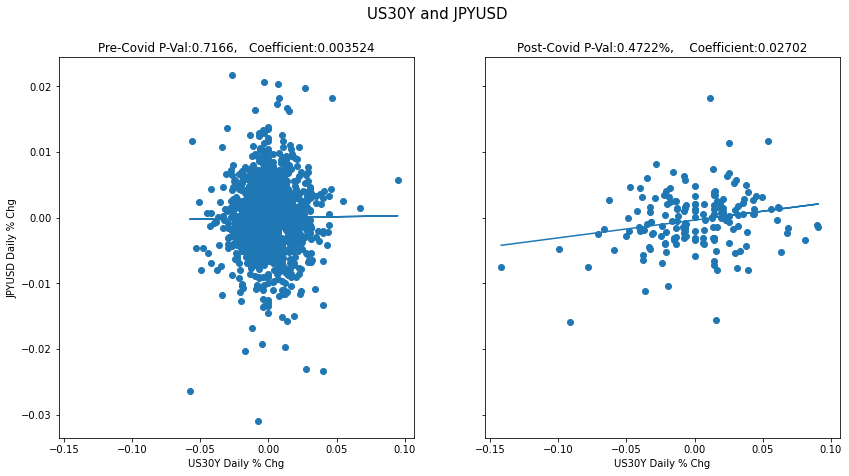

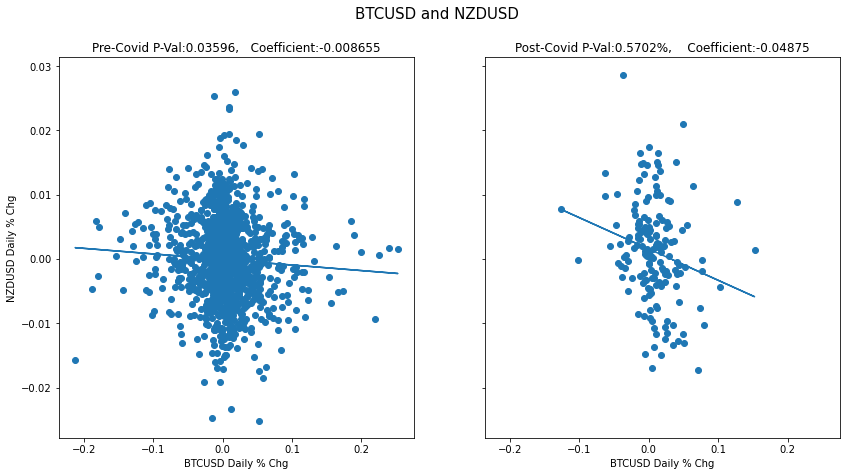

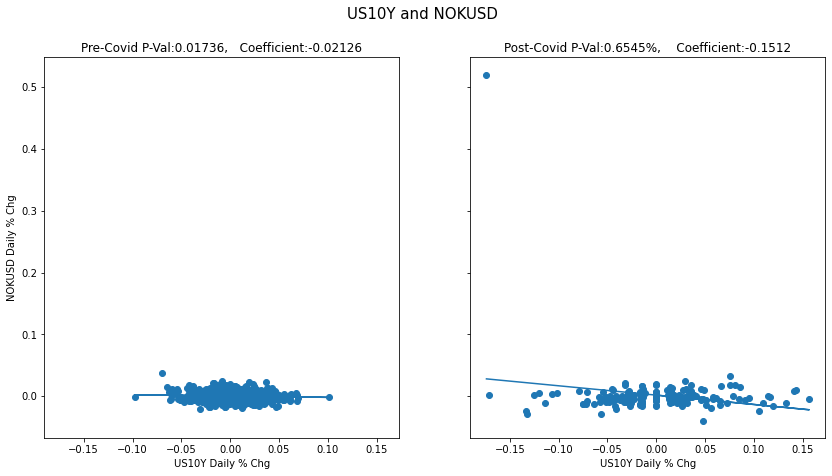

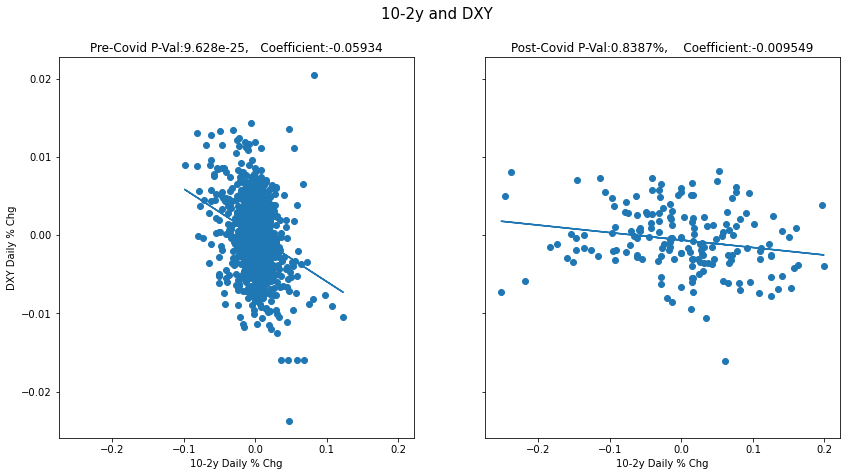

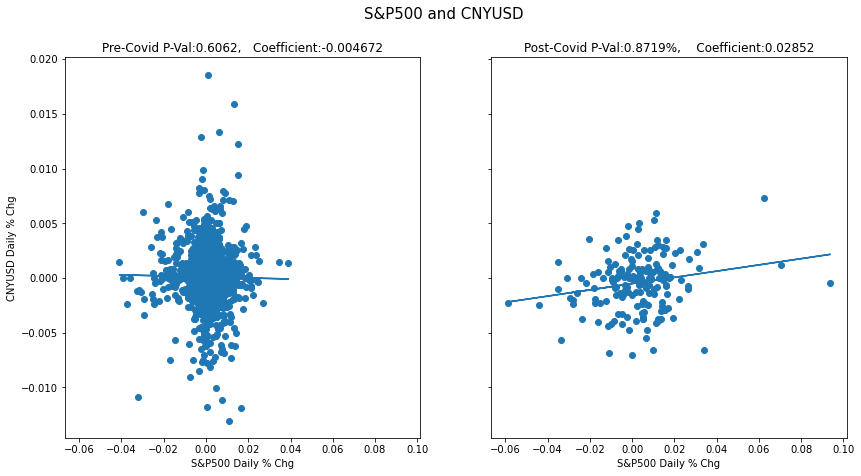

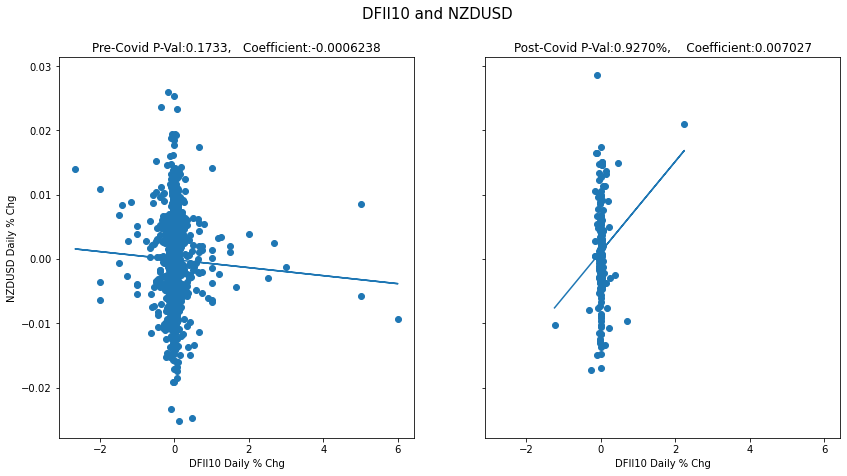

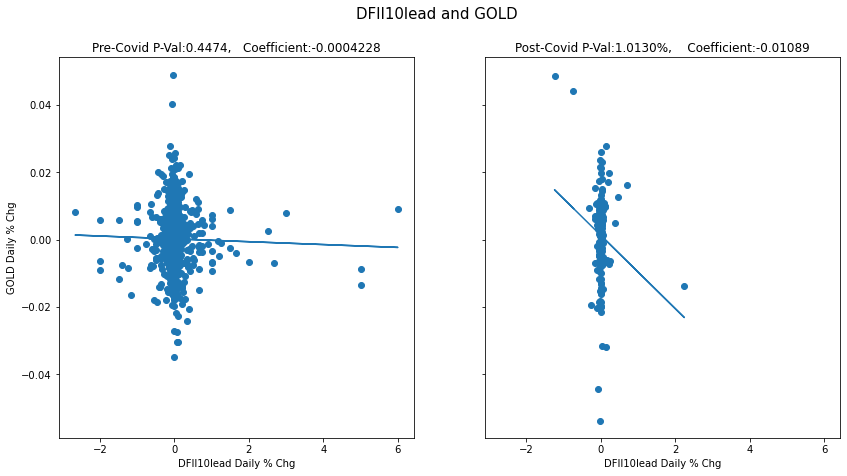

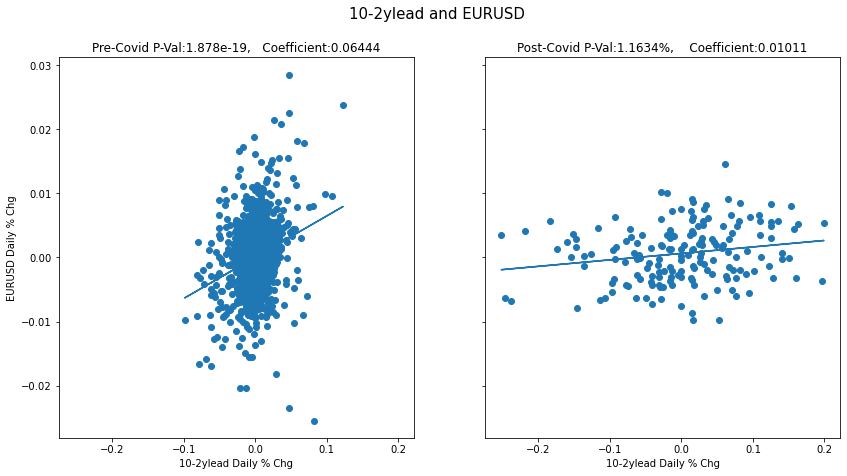

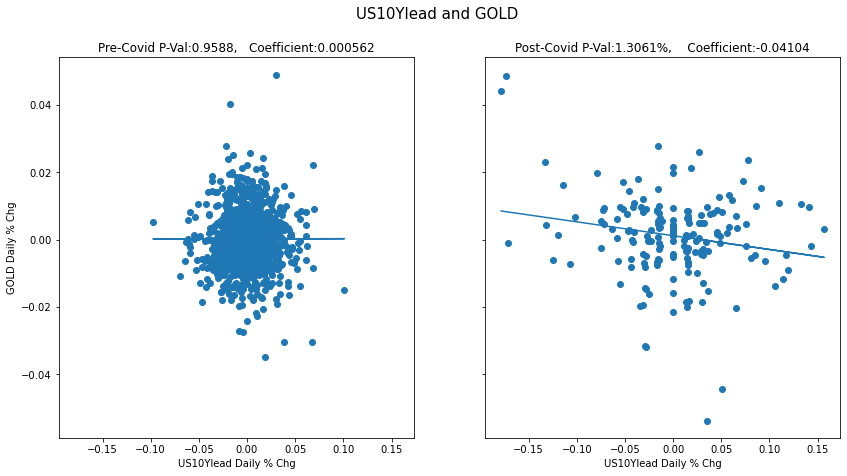

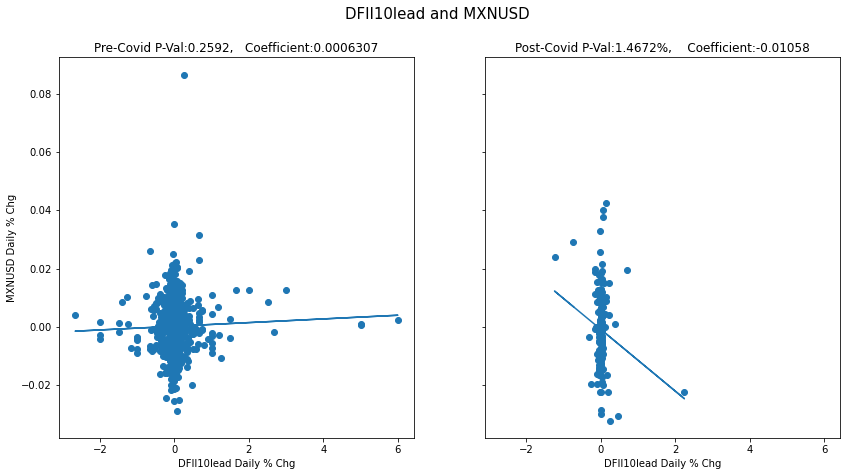

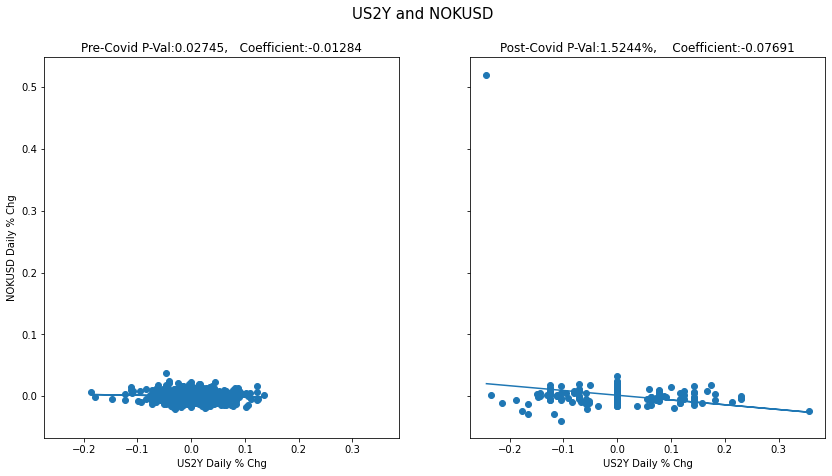

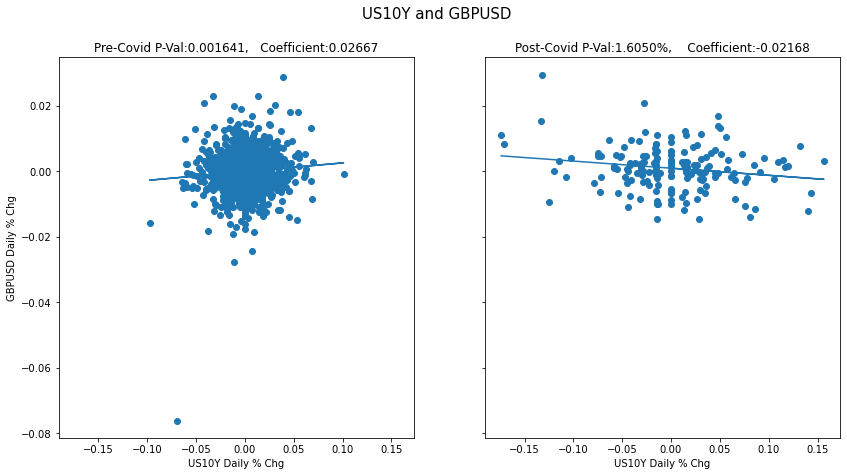

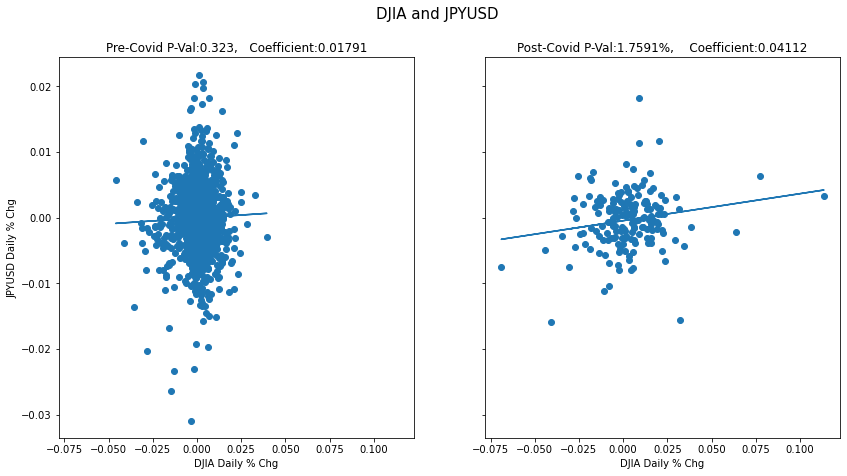

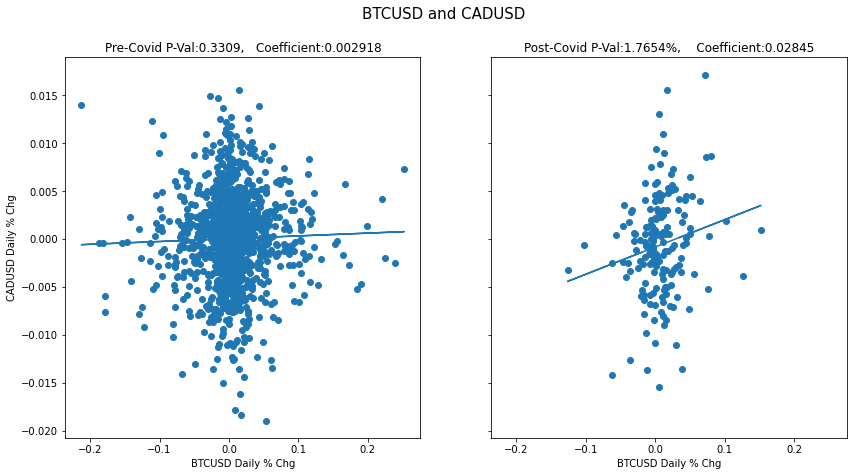

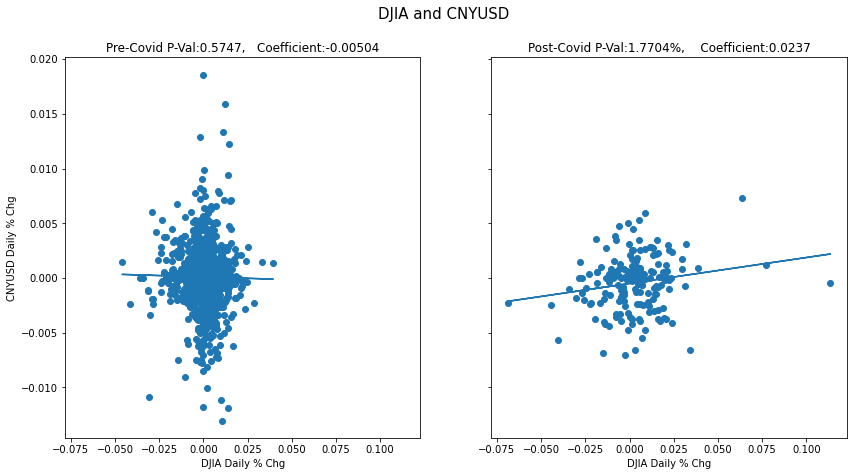

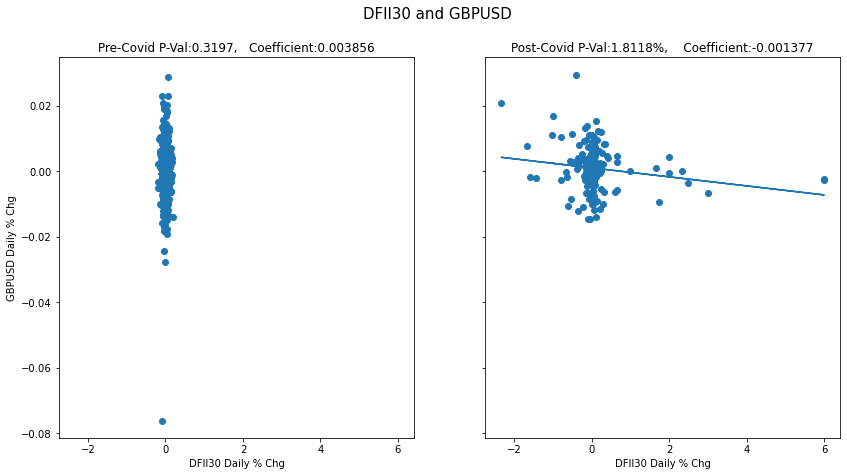

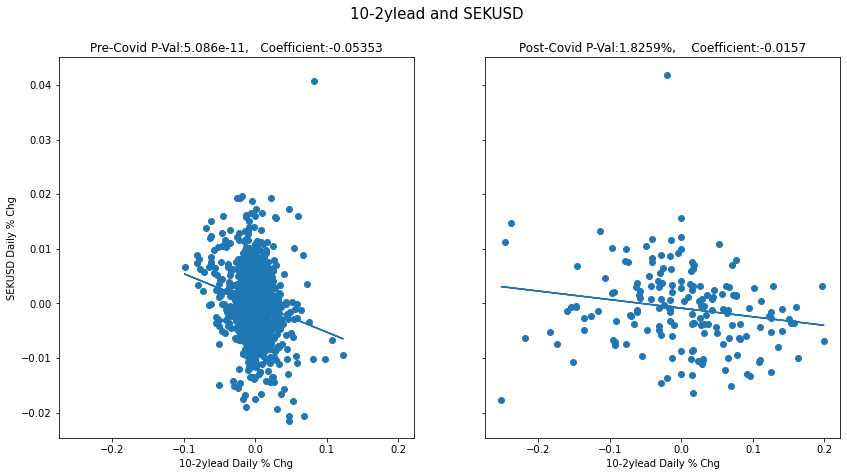

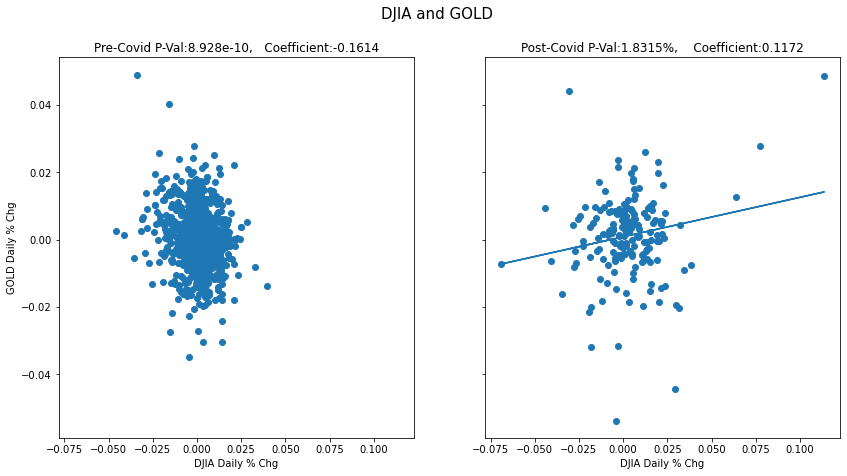

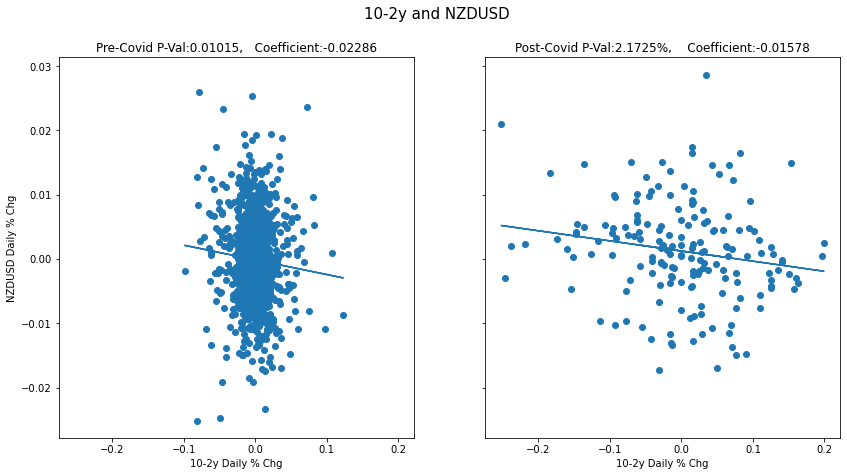

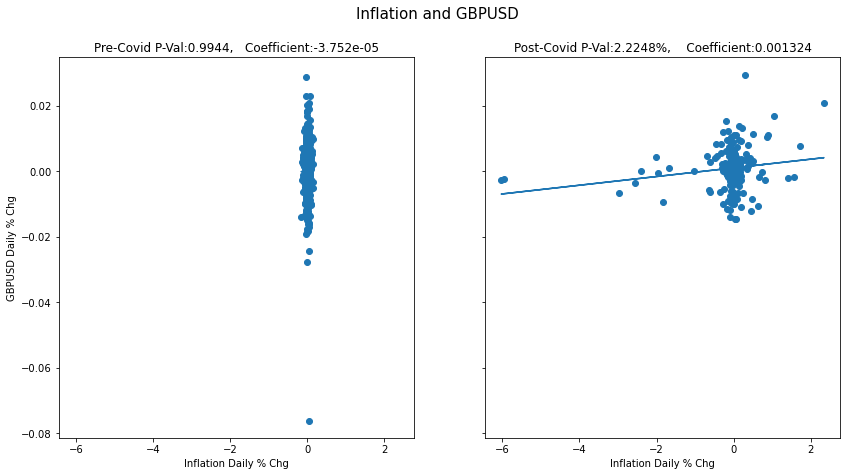

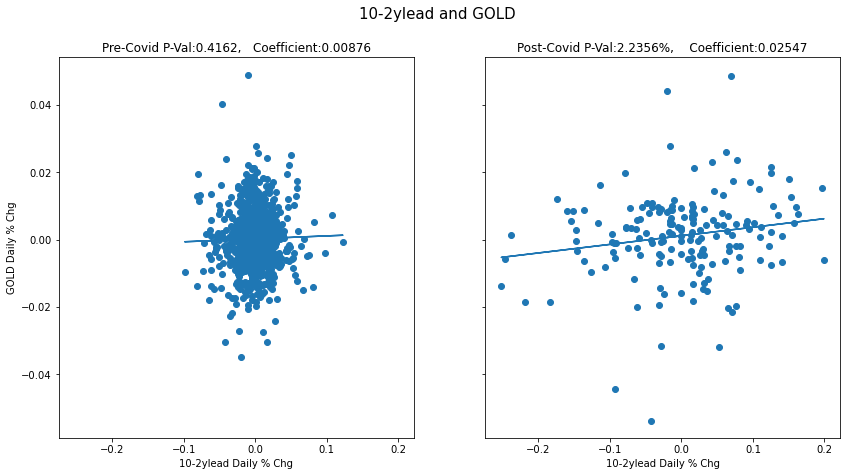

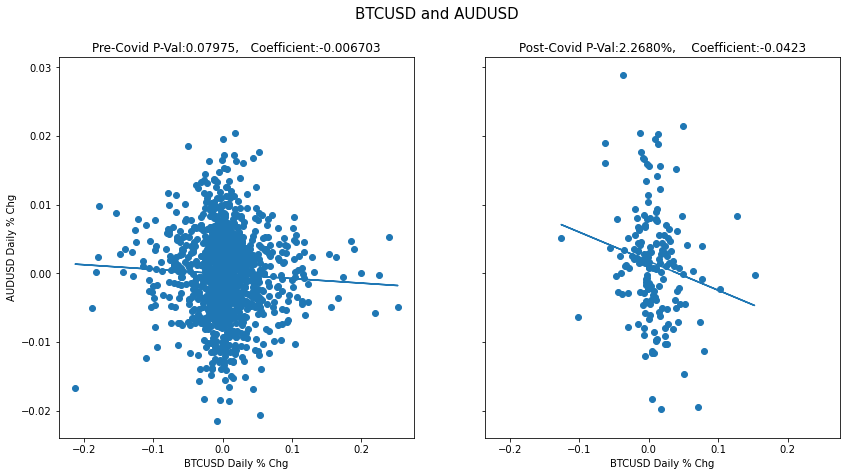

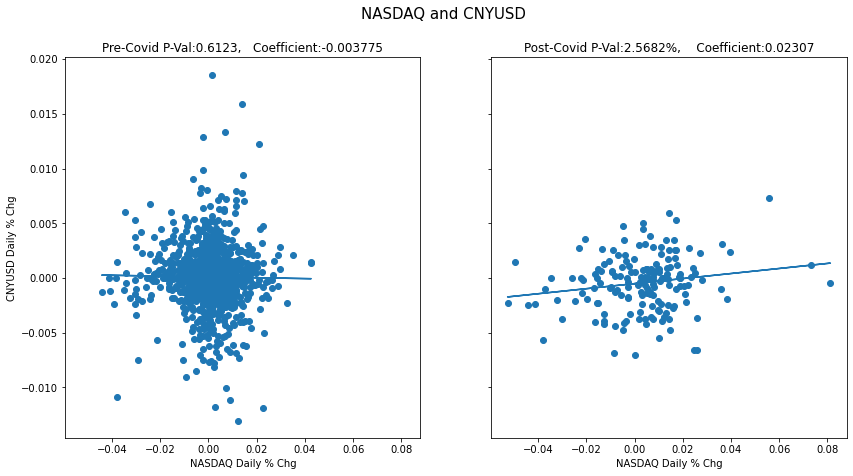

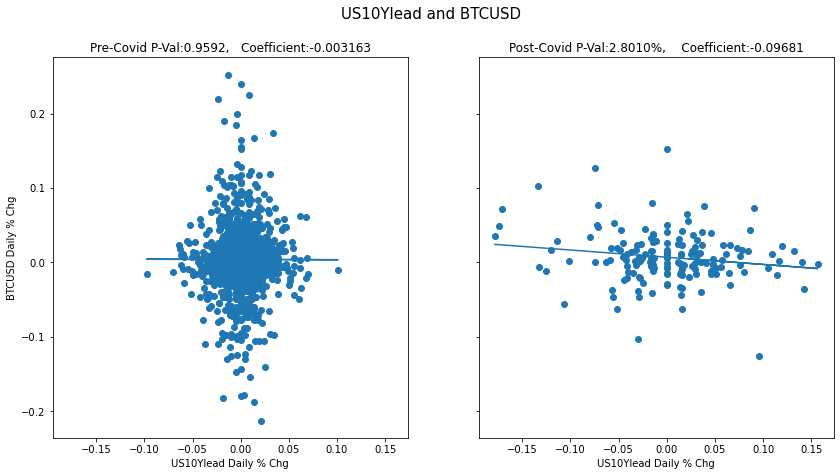

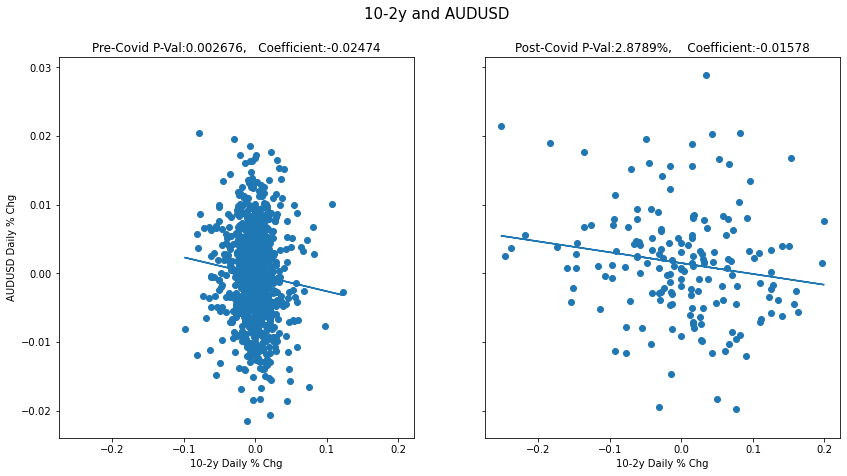

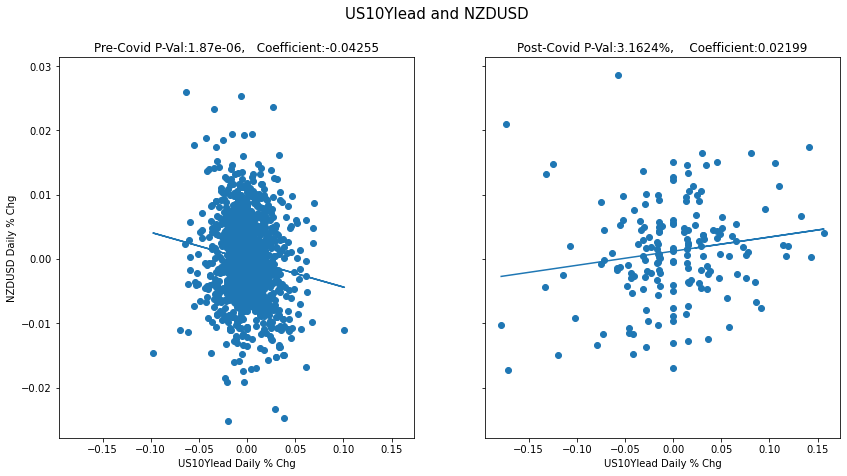

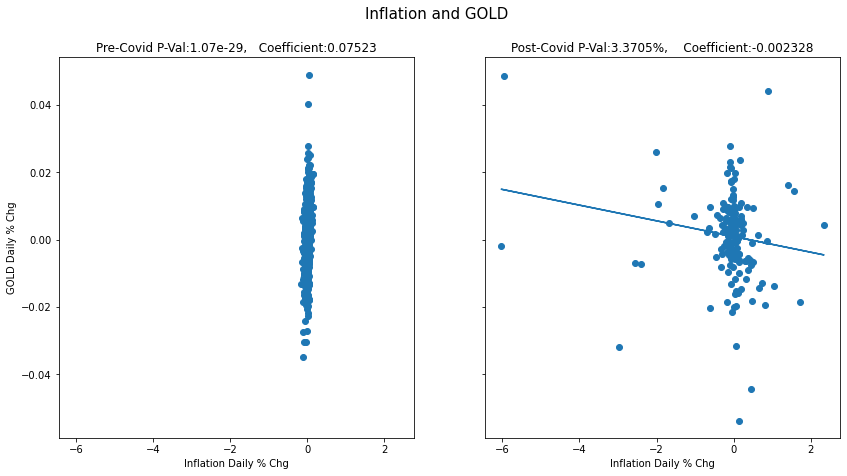

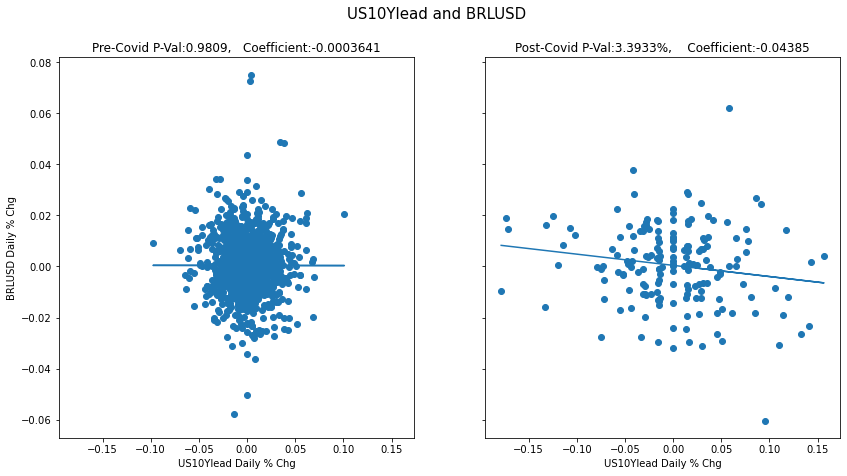

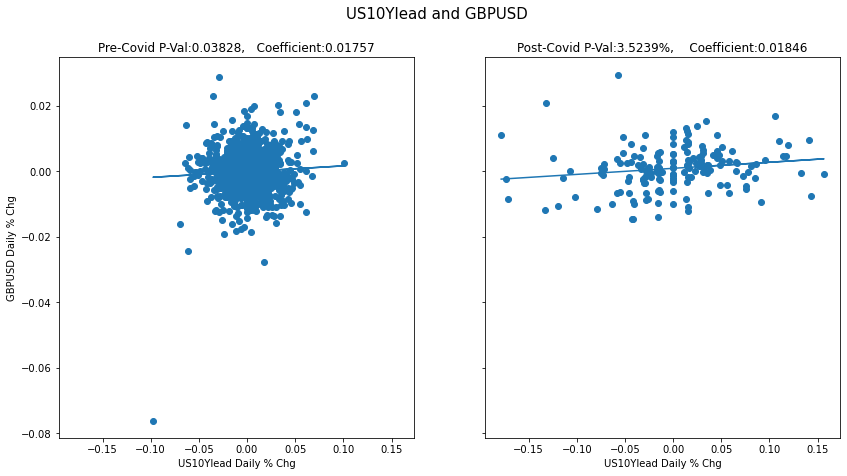

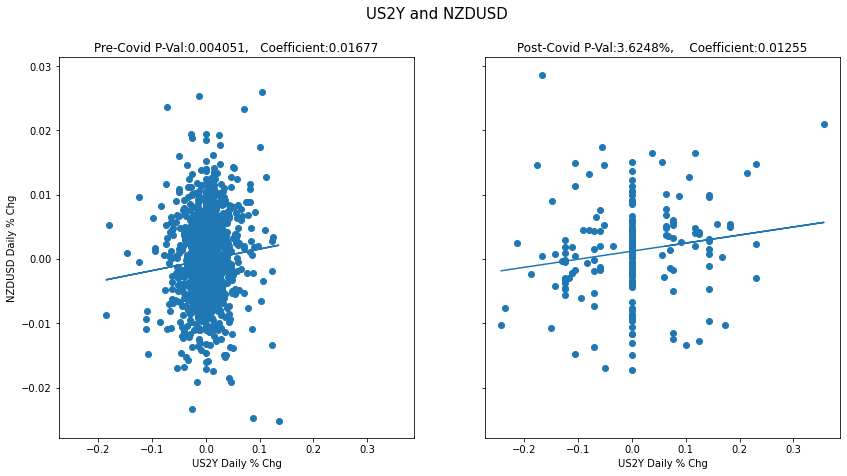

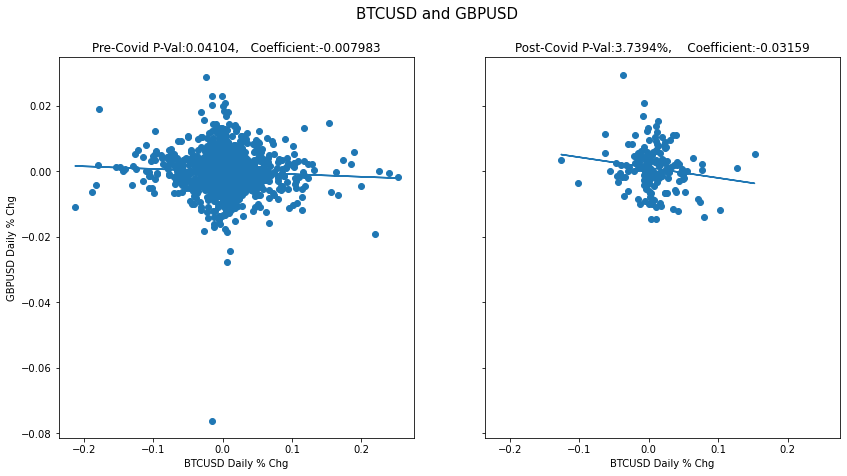

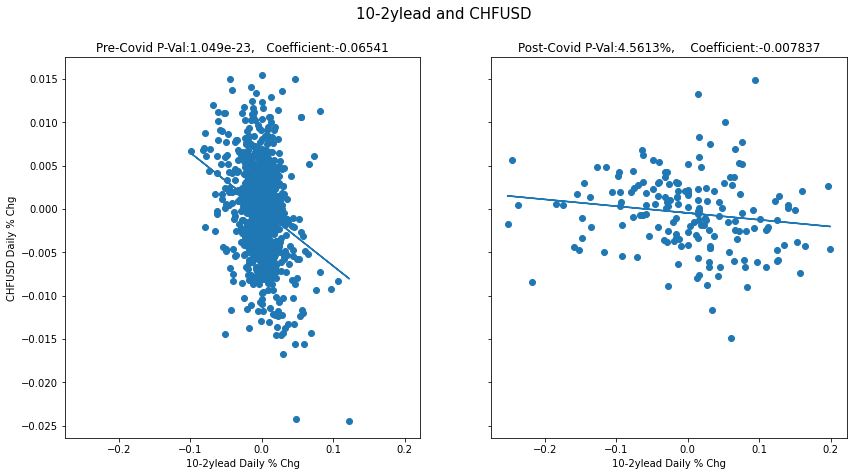

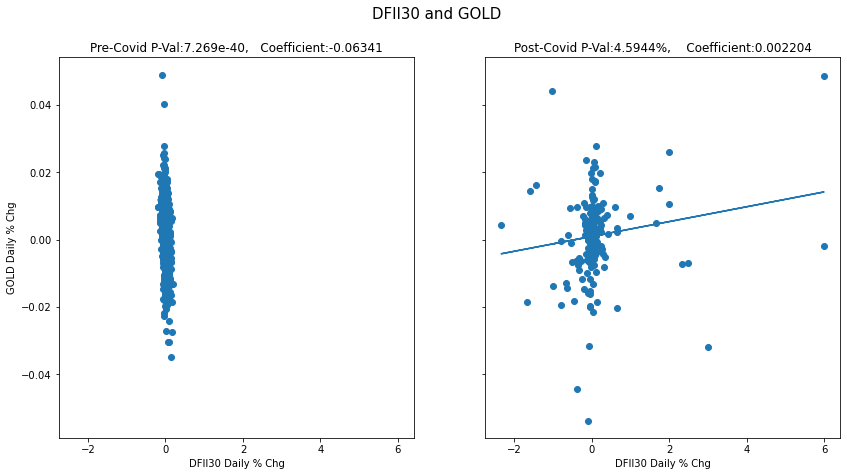

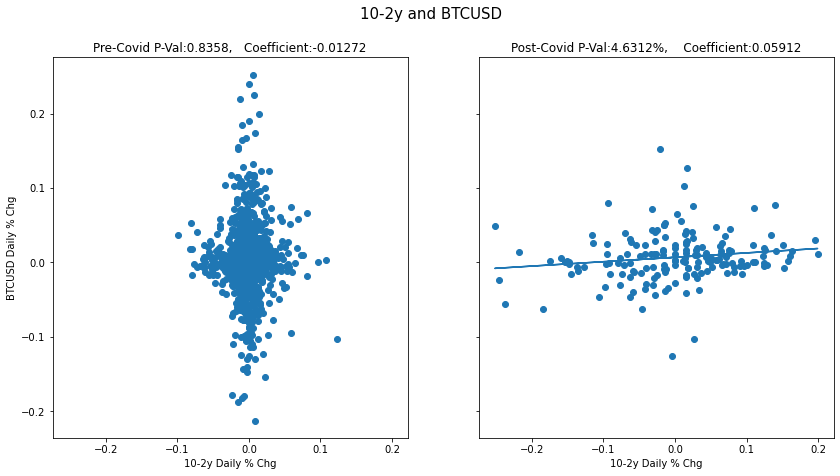

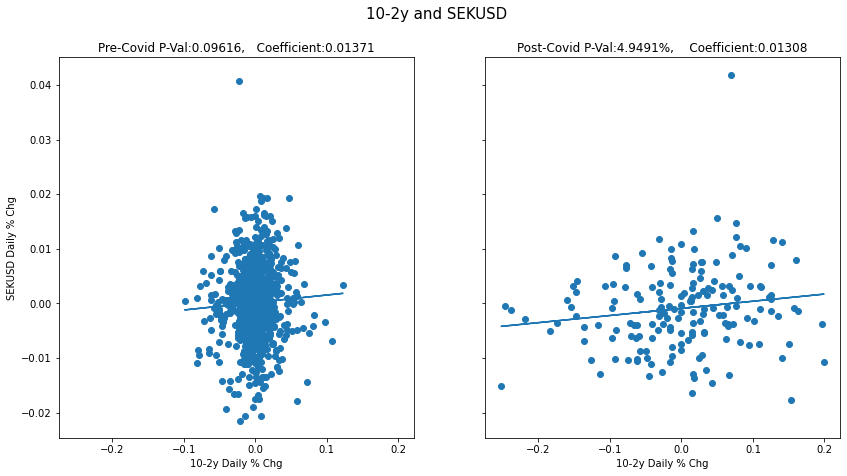

In [10]:
for item in sorted_d:
    x1 = xpre[item[3][0]]
    y1 = ypre[item[3][1]]
    x2 = xpost[item[3][0]]
    y2 = ypost[item[3][1]]
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,7), sharex=True, sharey=True)
    axes[0].scatter(x1, y1)
    axes[0].set_title(f'Pre-Covid P-Val:{item[2][0]:.4},   Coefficient:{item[2][1]:.4}')
    axes[0].set_ylabel(f'{item[3][1]} Daily % Chg')
    axes[0].set_xlabel(f'{item[3][0]} Daily % Chg')
    axes[1].set_title(f'Post-Covid P-Val:{item[0]:.4%},    Coefficient:{item[1]:.4}')
    plt.xlabel(f'{item[3][0]} Daily % Chg')
    if item[1] < 0.05:
        m, b = np.polyfit(x1, y1, 1)
        axes[0].plot(x1, m*x1 + b)
    m2,b2 = np.polyfit(x2, y2, 1)
    axes[1].plot(x2, m2*x2 + b2)
    plt.suptitle(f'{item[3][0]} and {item[3][1]}',fontsize=15)
    axes[1].scatter(x2, y2)
    fig.show()

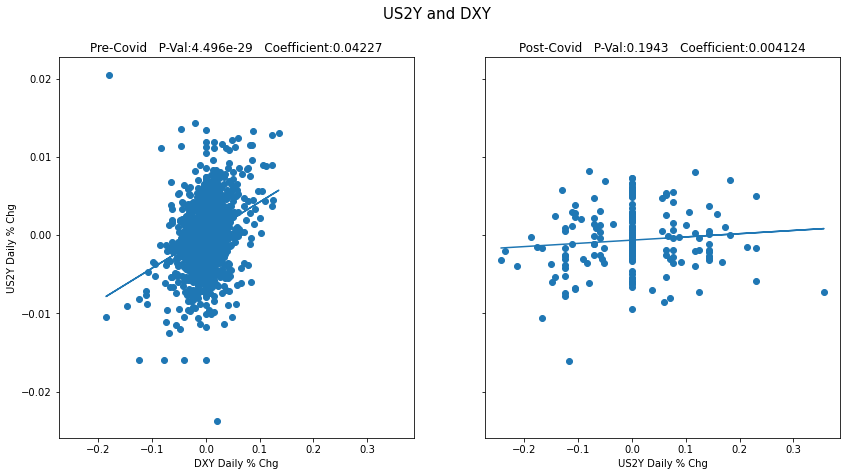

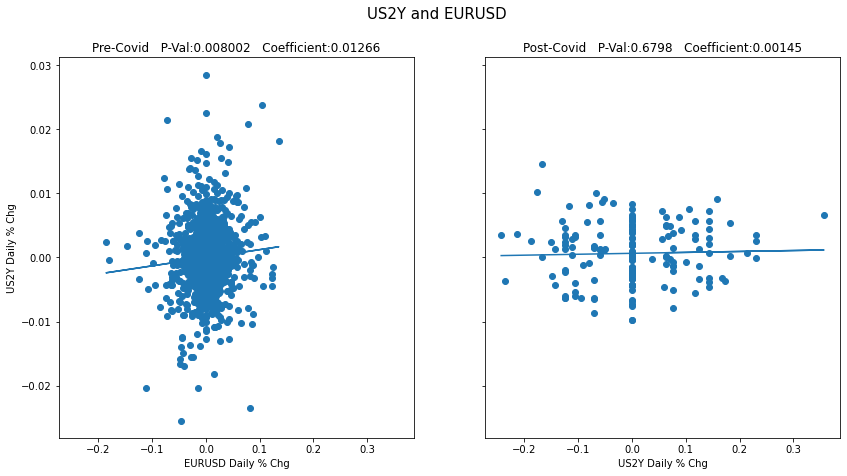

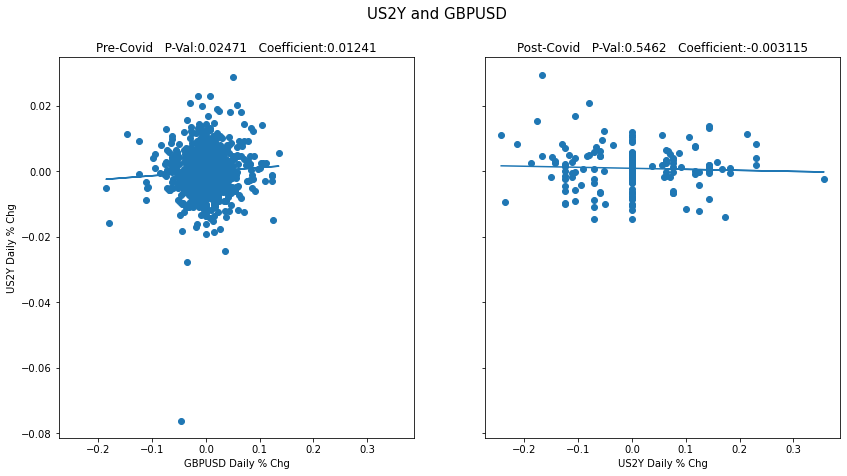

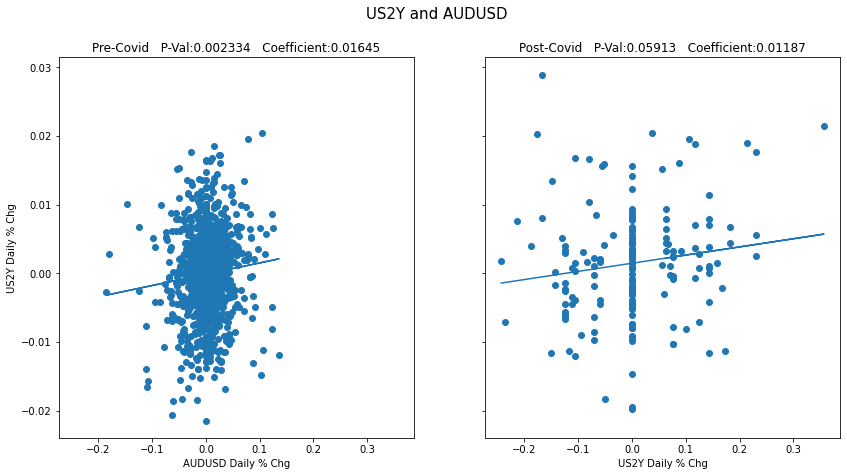

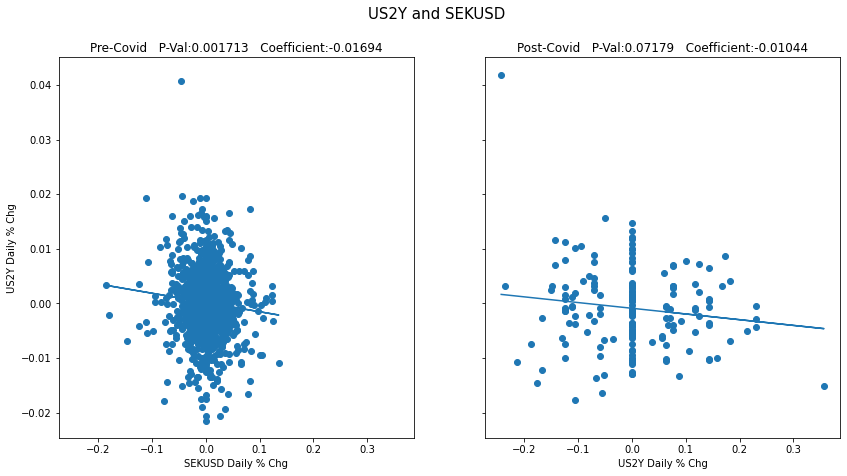

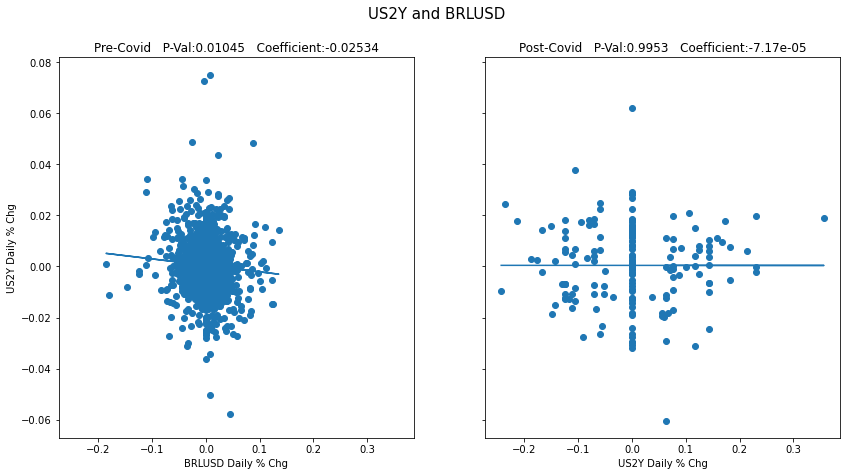

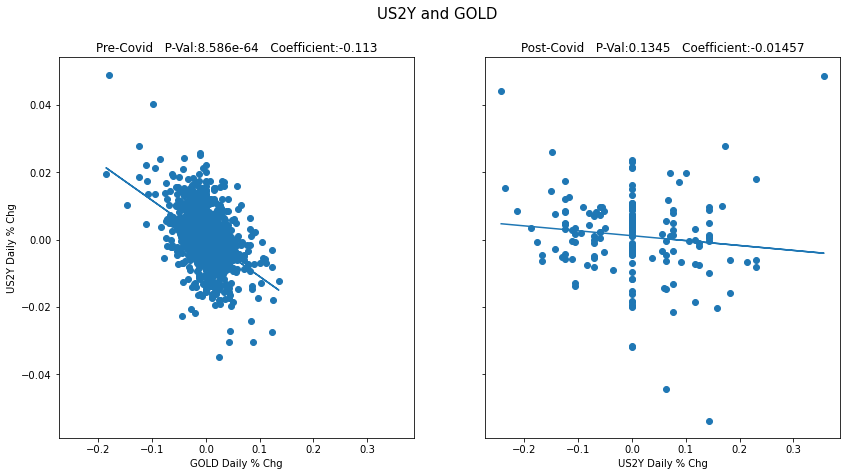

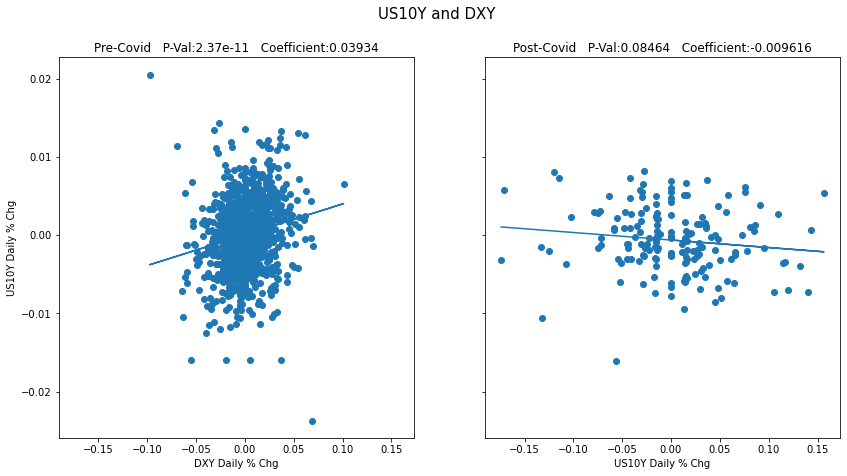

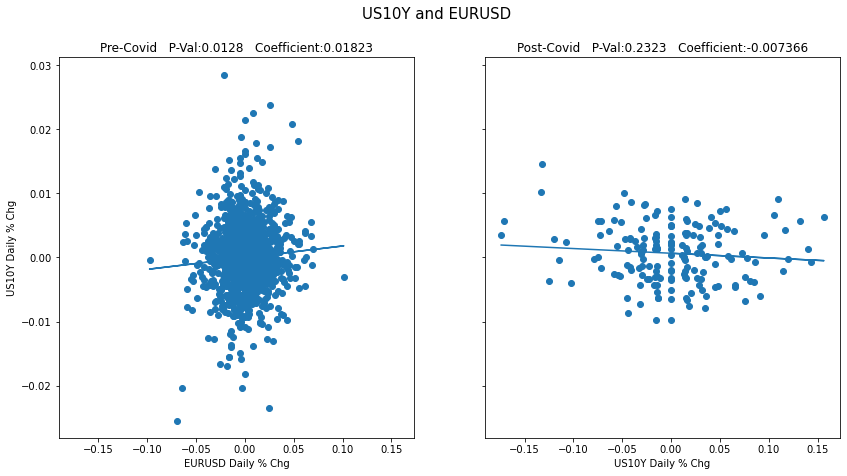

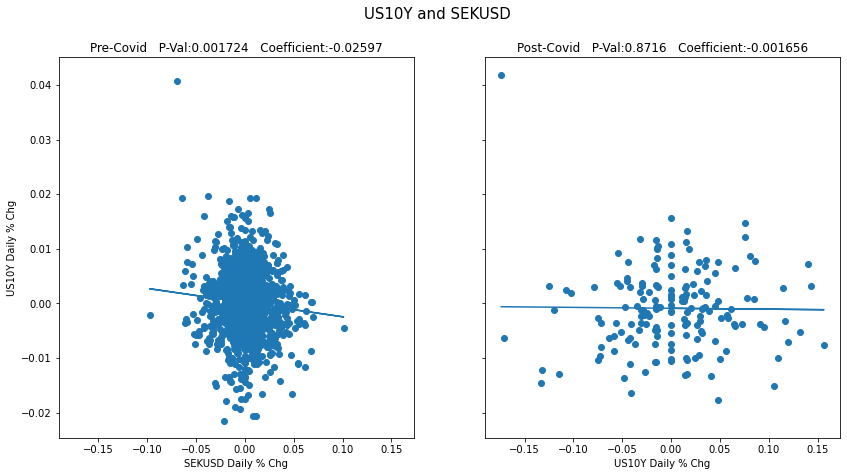

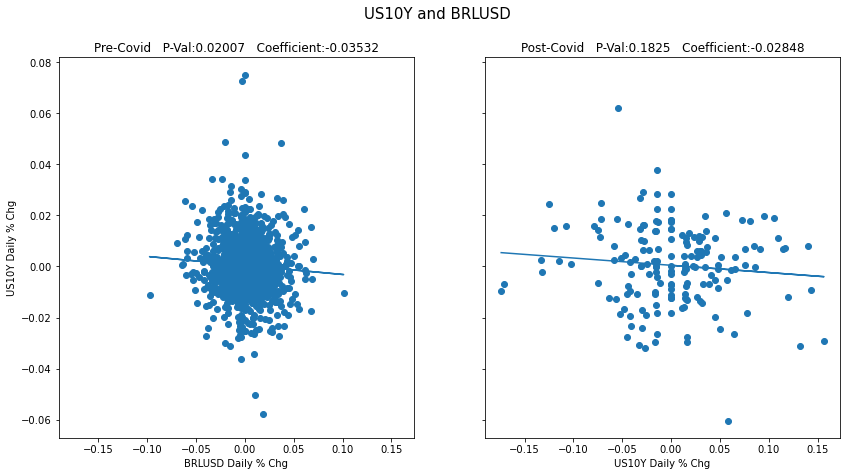

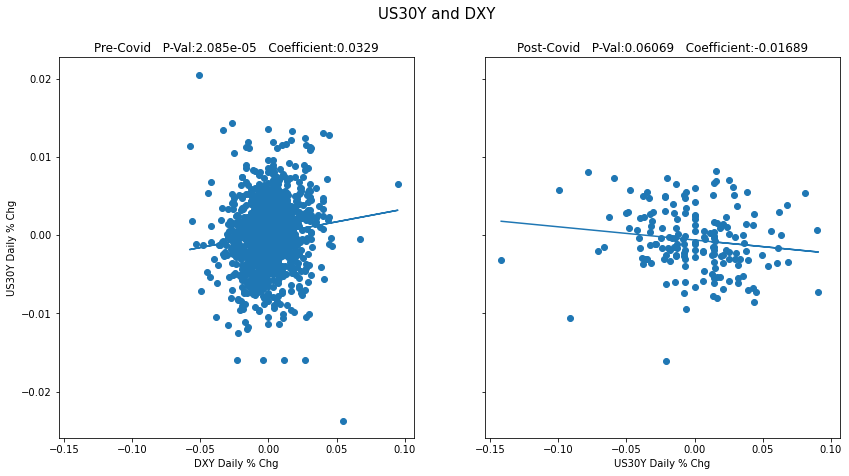

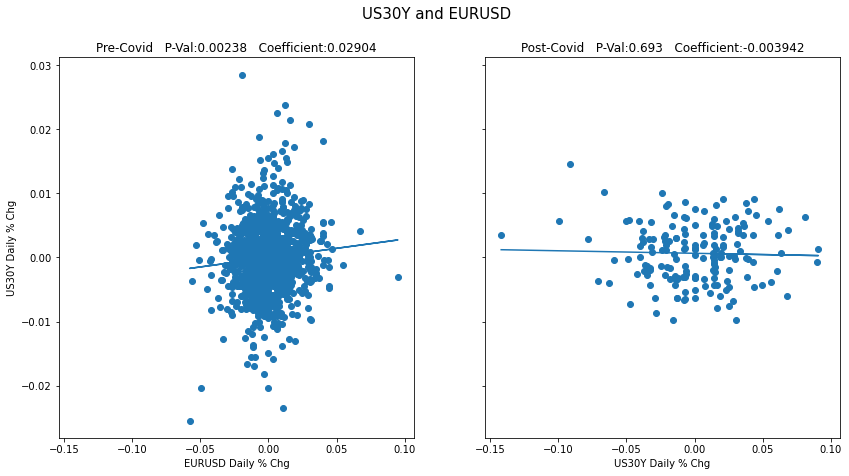

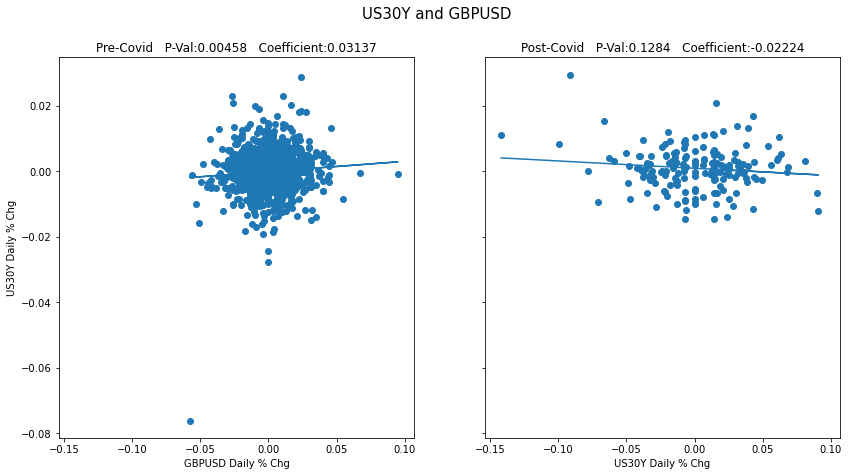

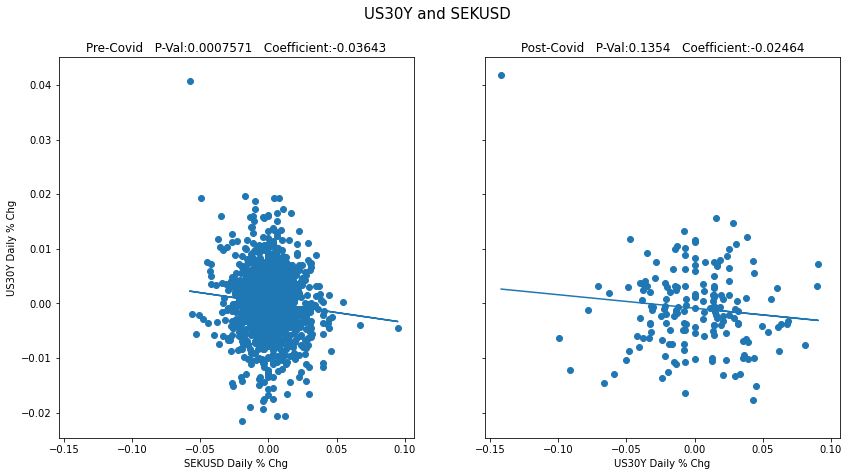

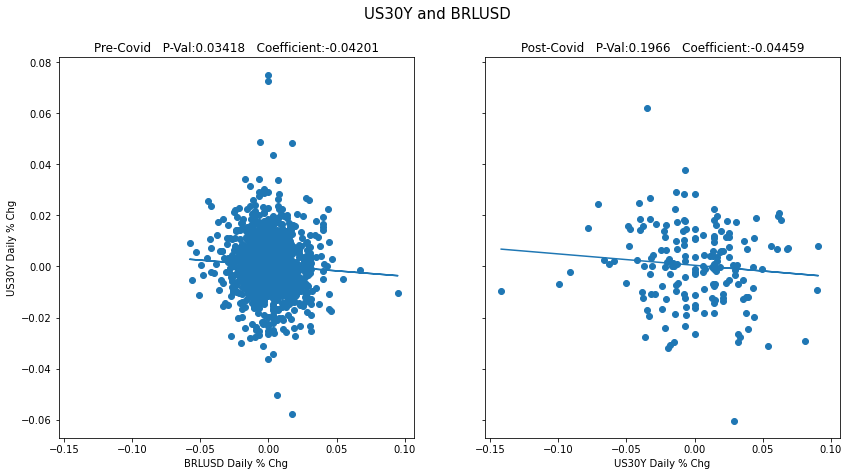

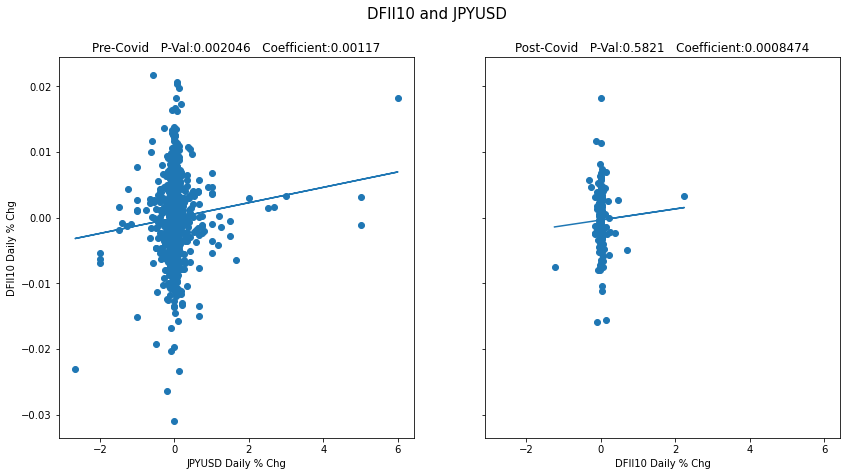

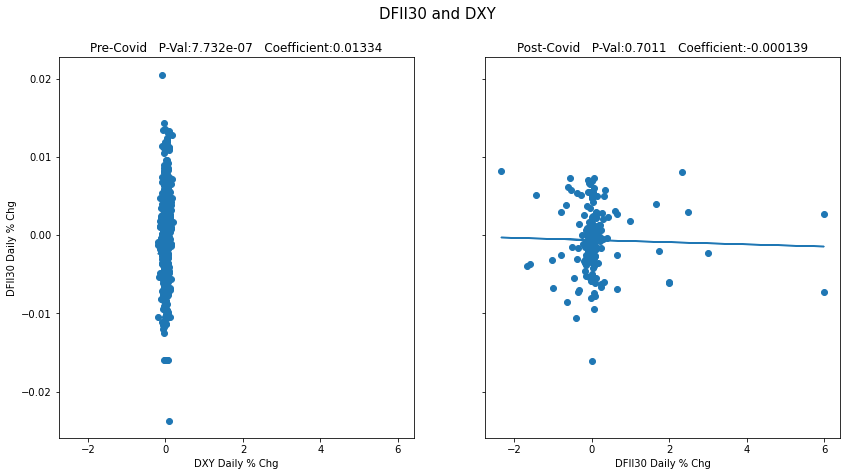

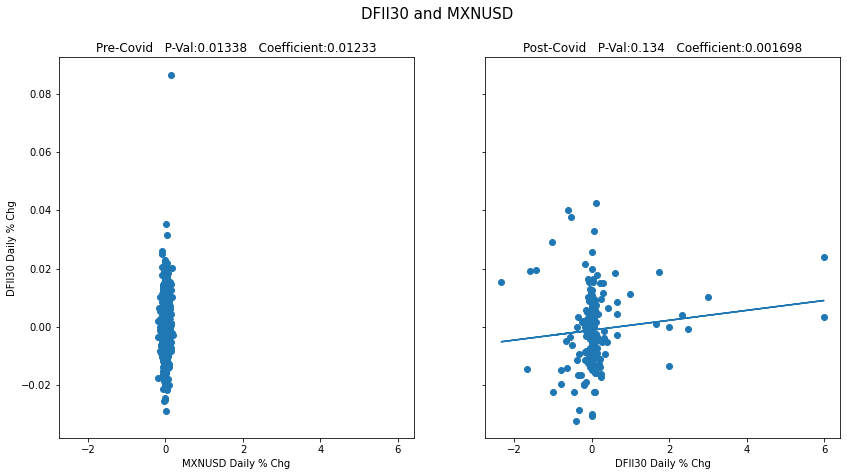

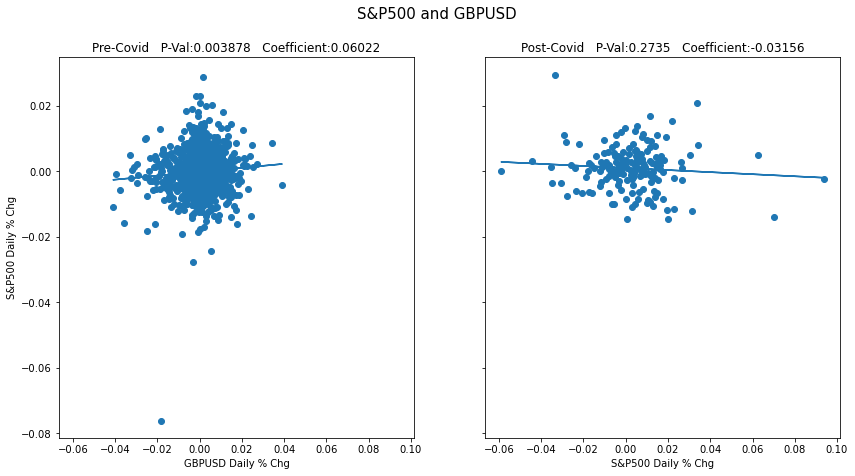

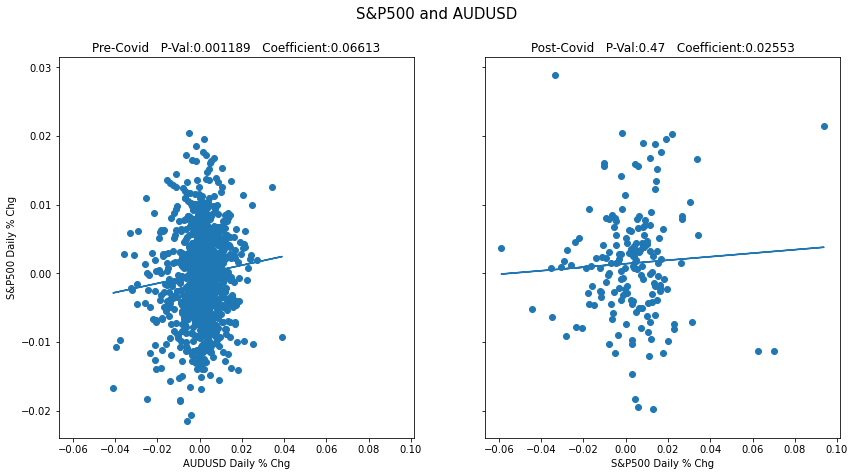

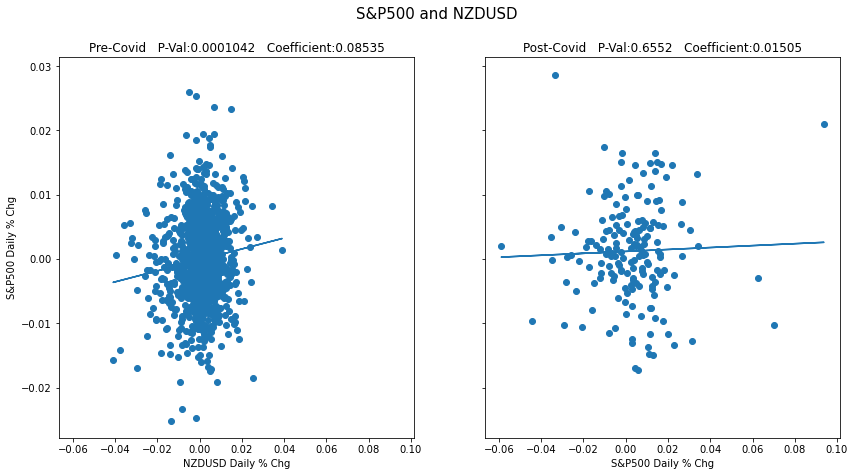

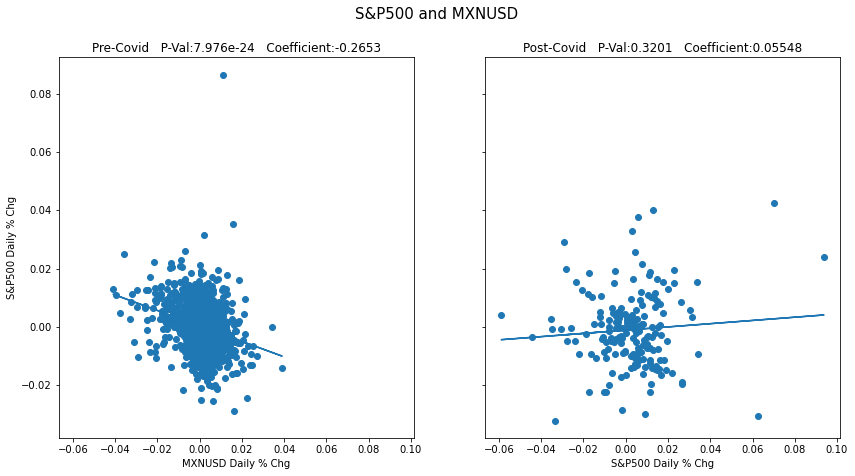

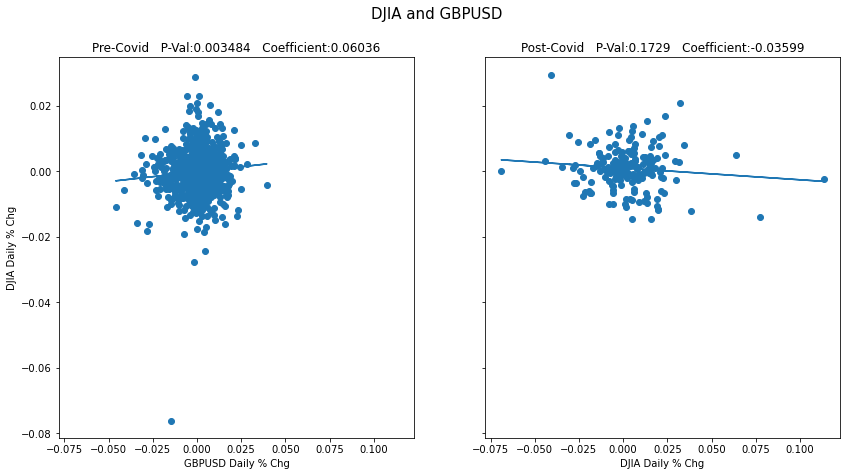

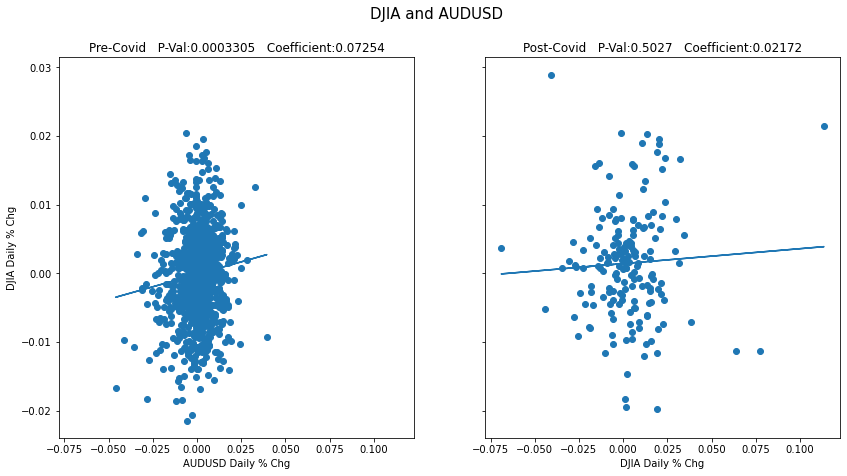

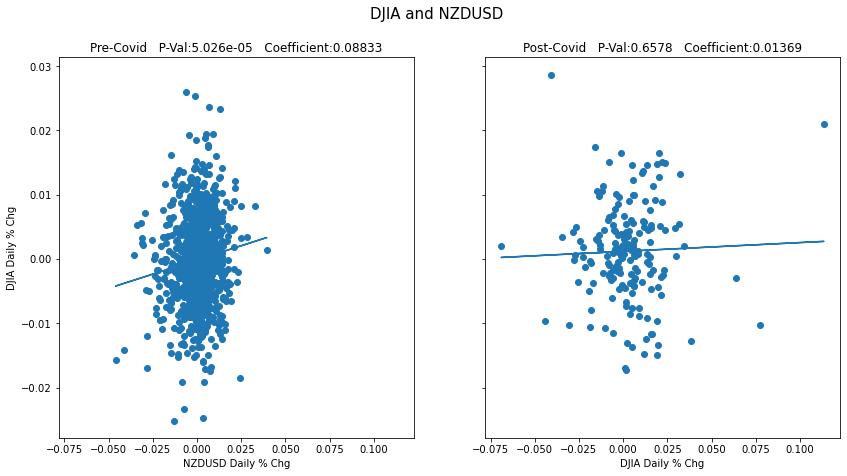

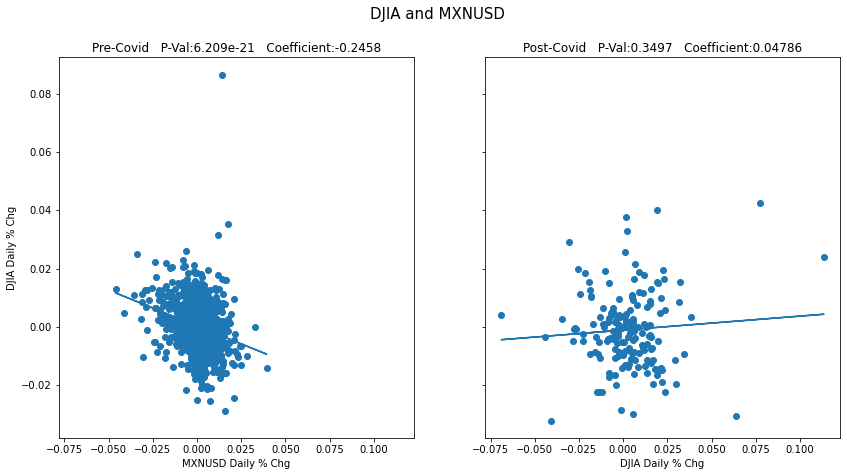

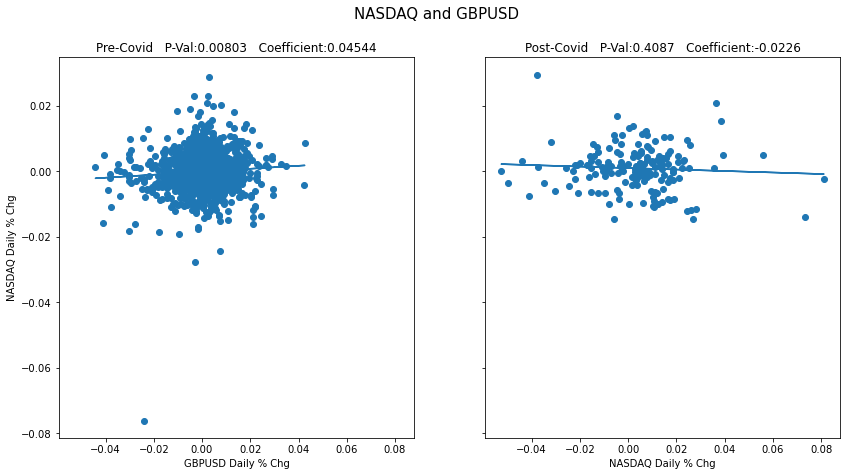

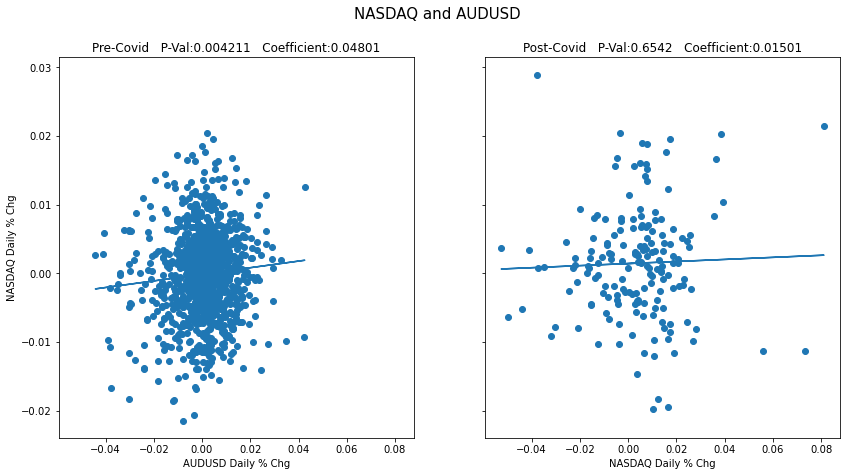

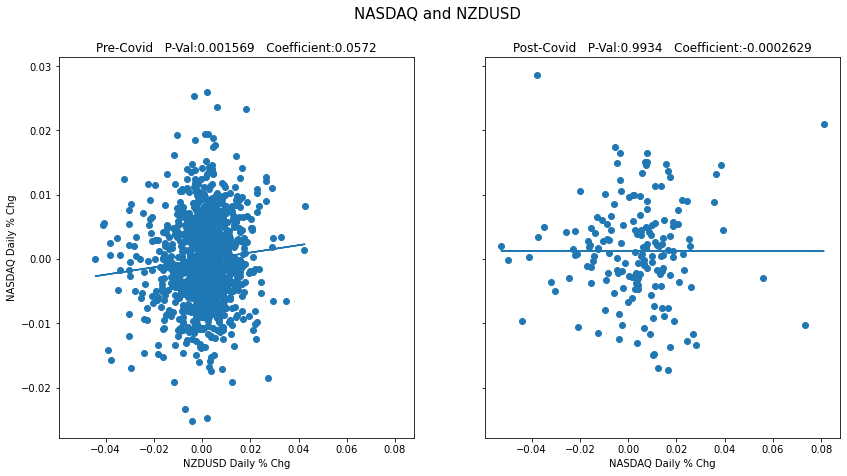

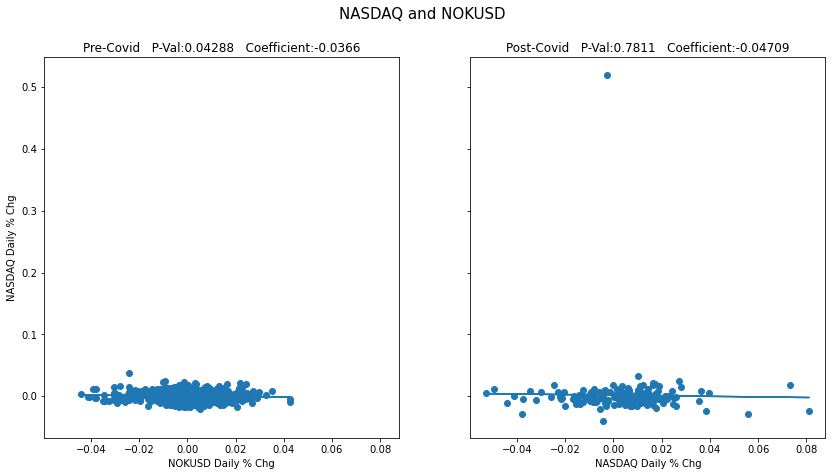

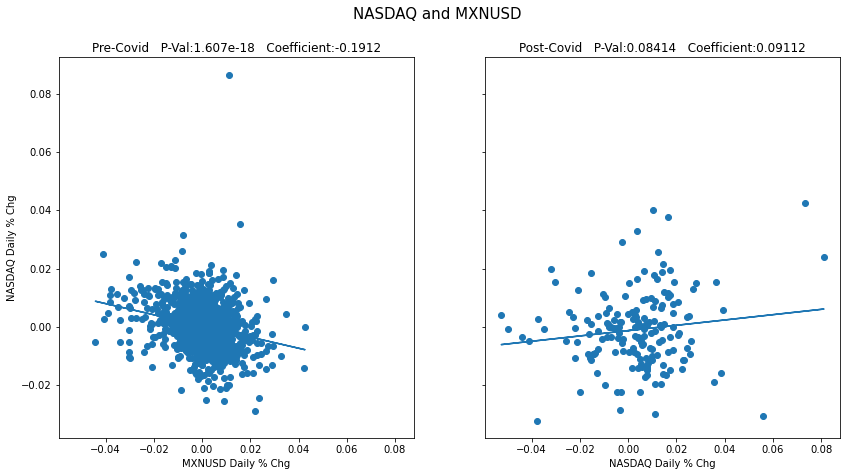

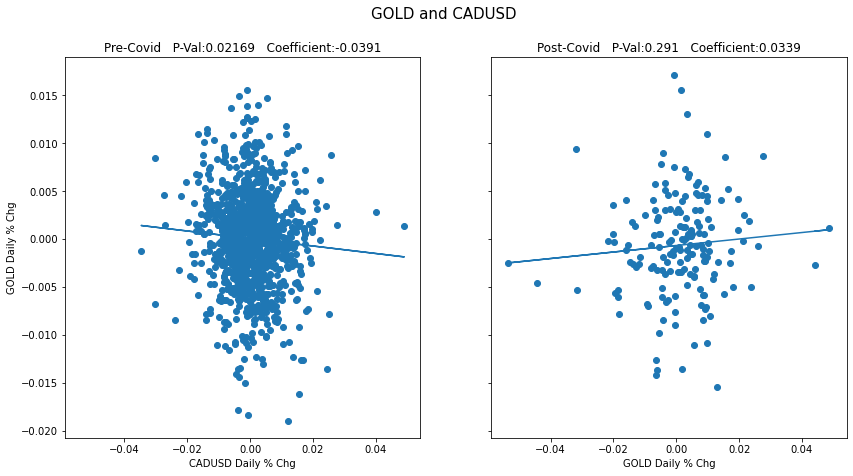

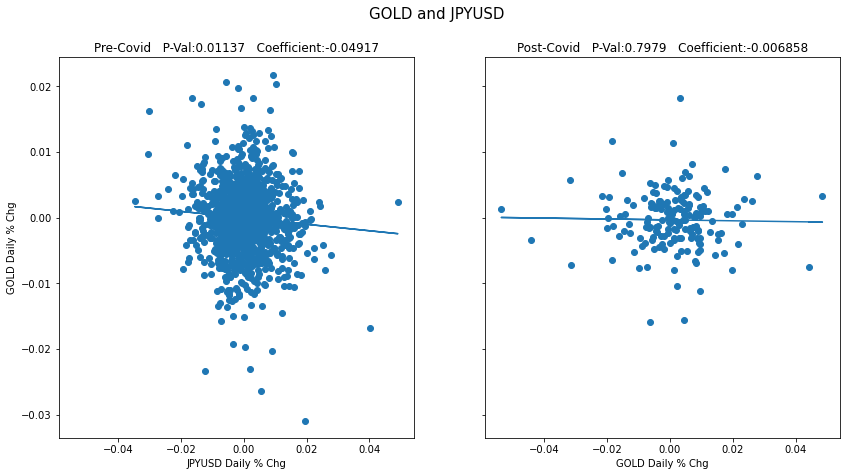

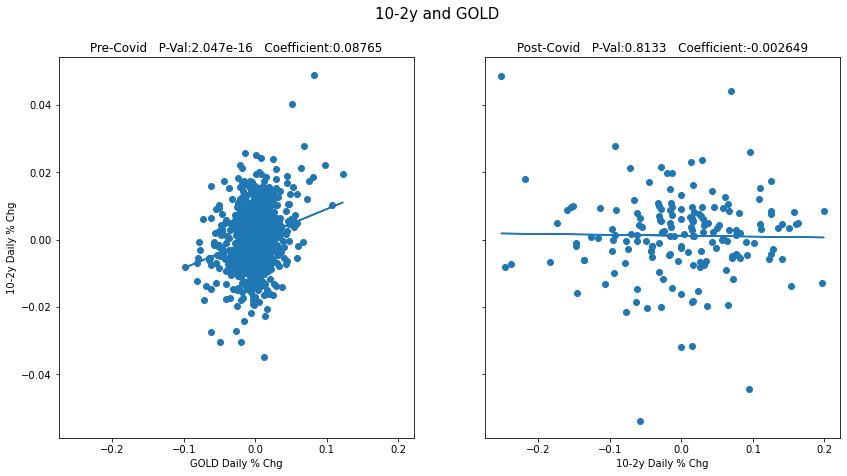

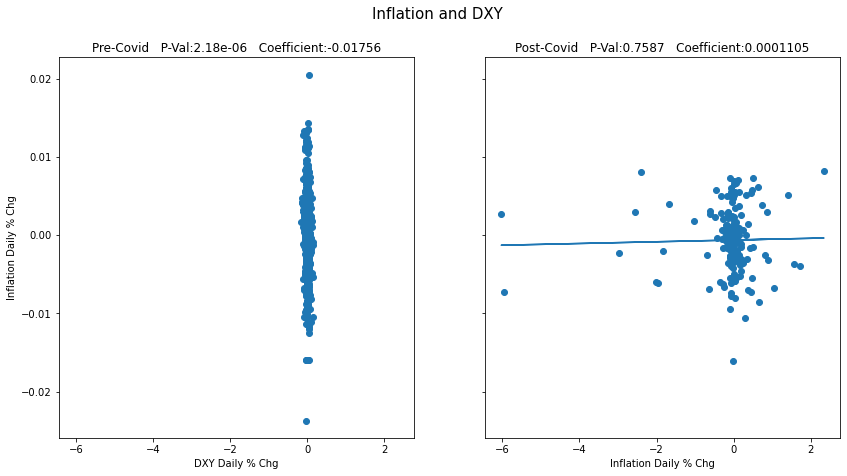

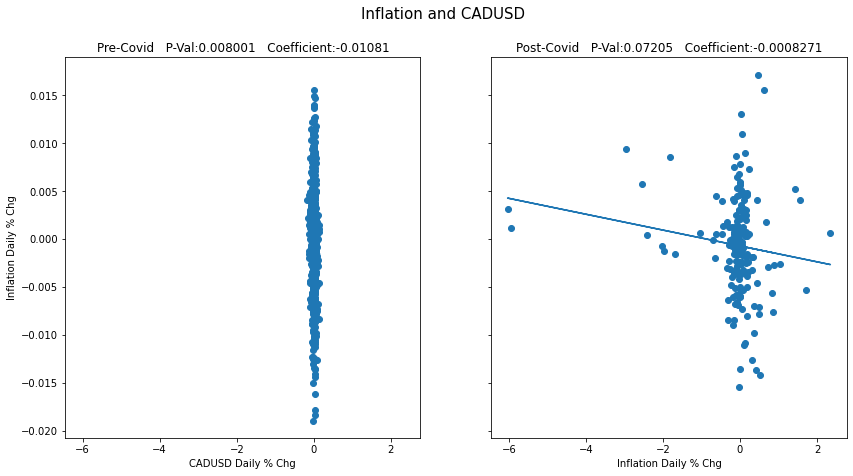

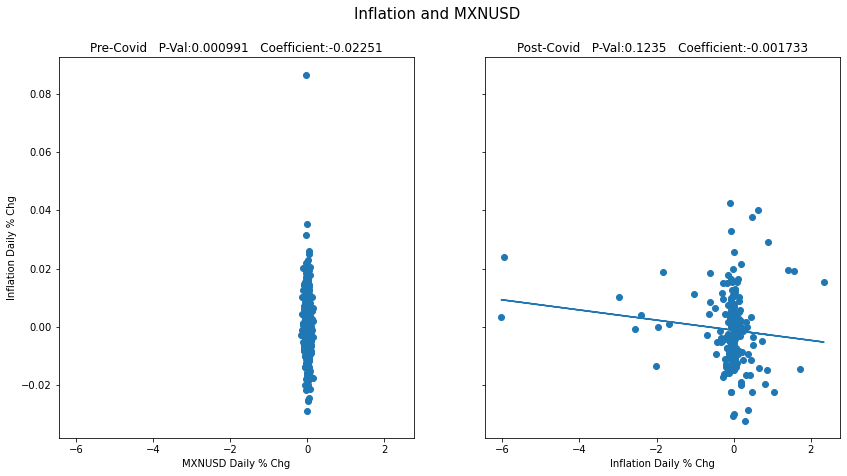

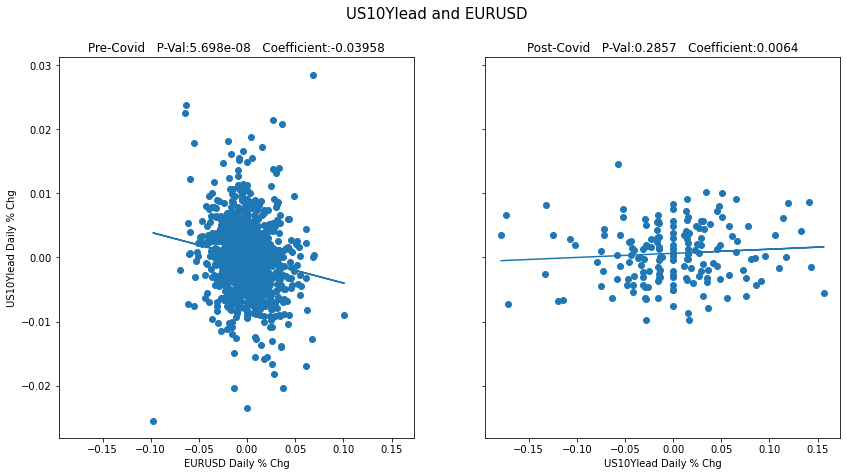

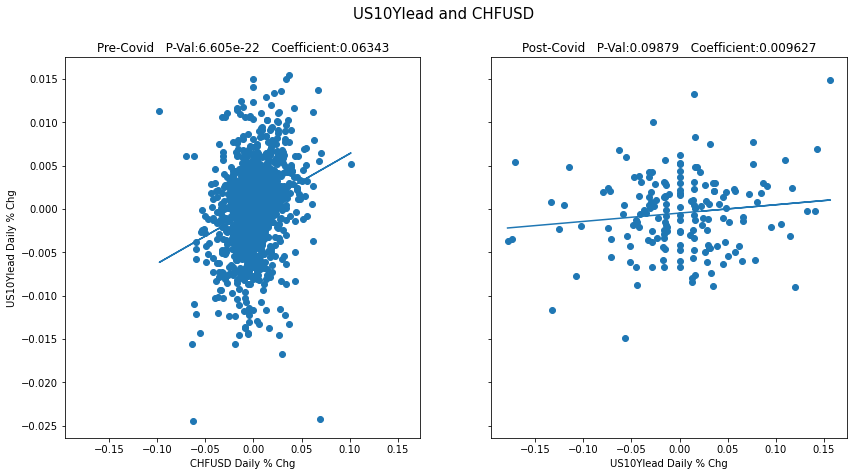

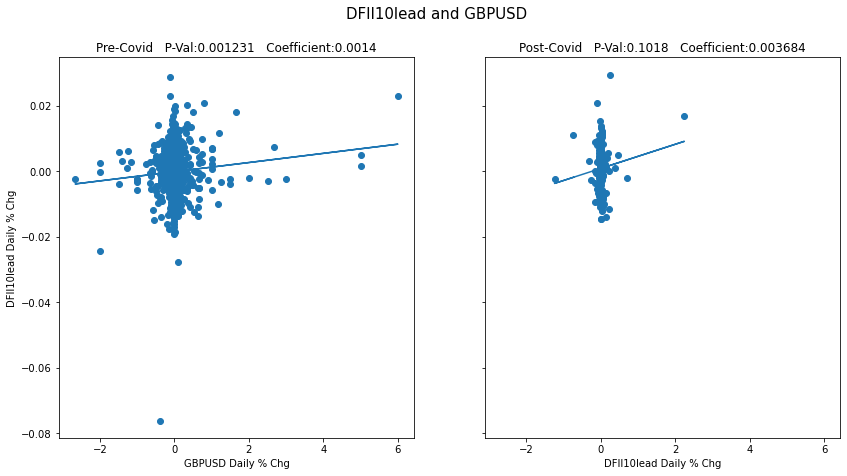

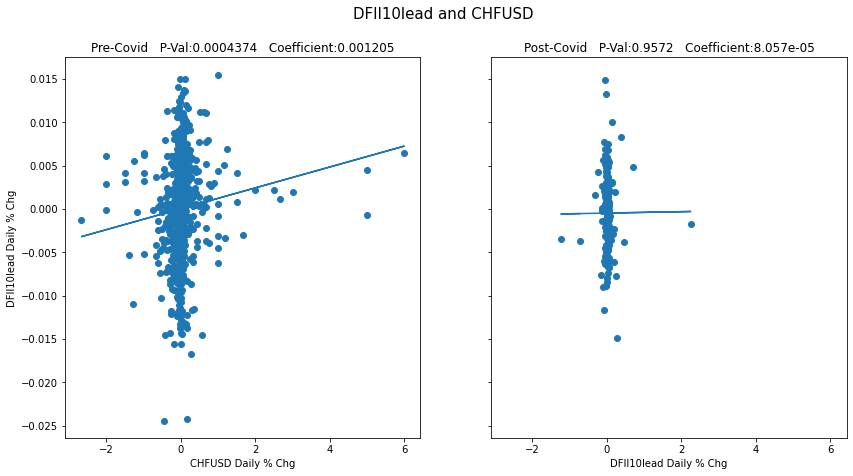

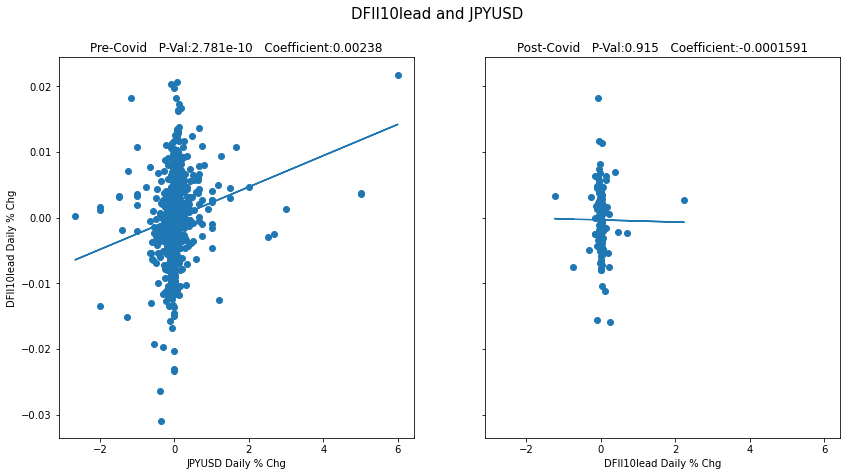

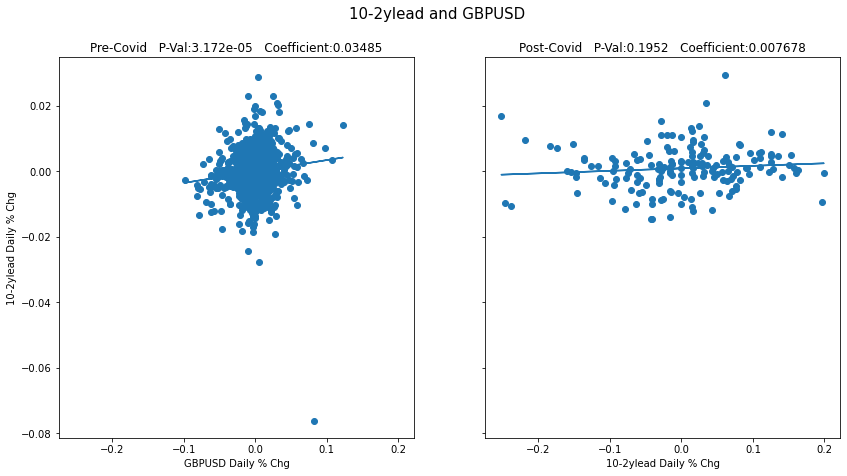

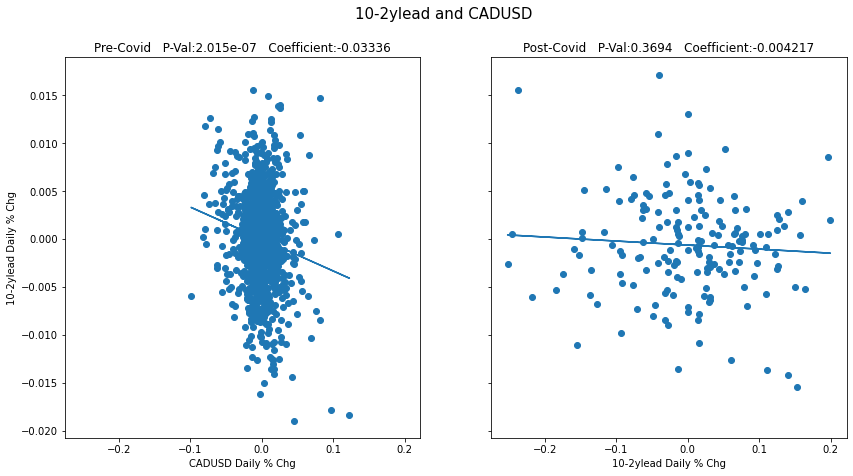

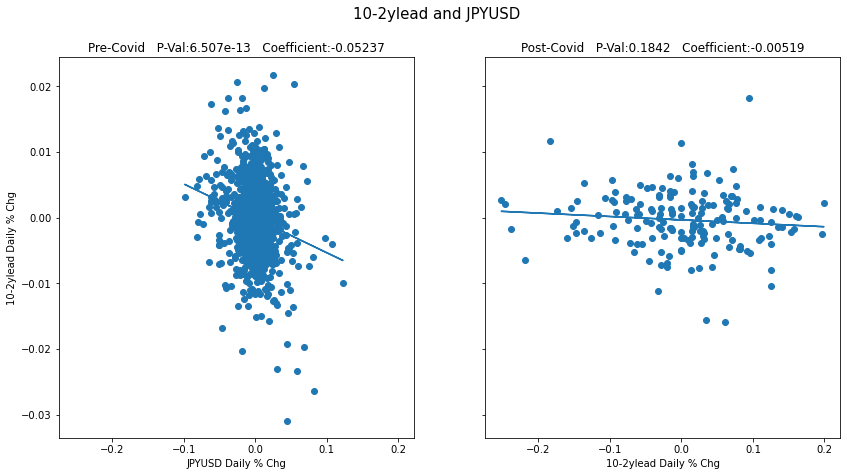

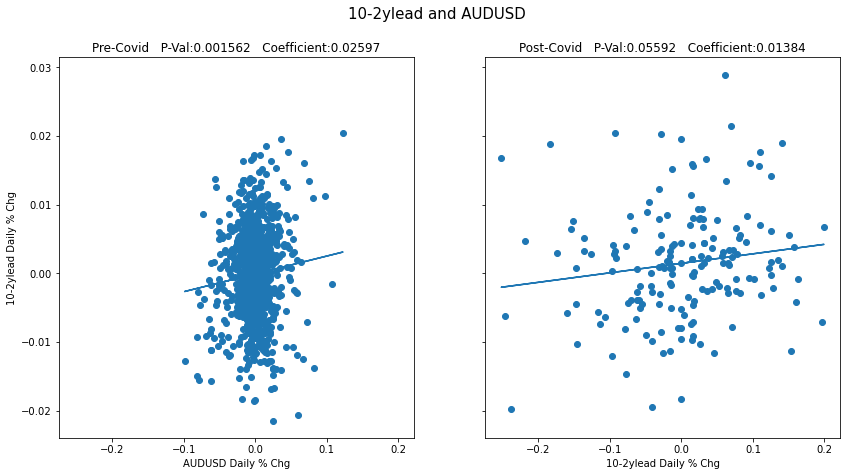

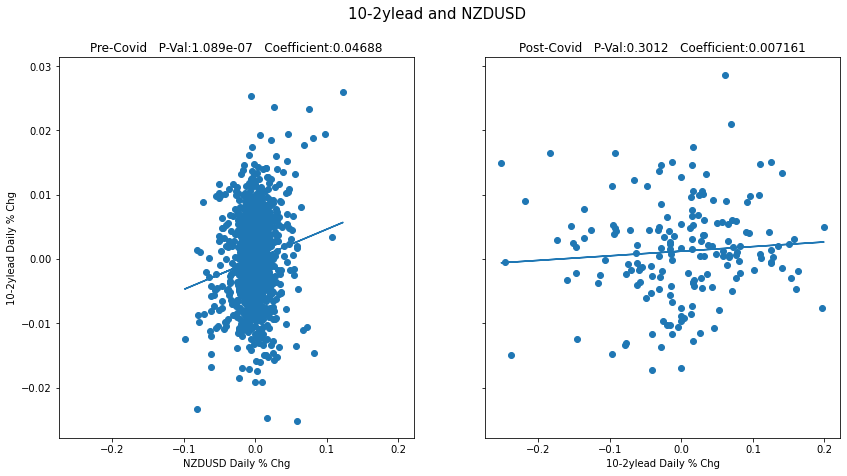

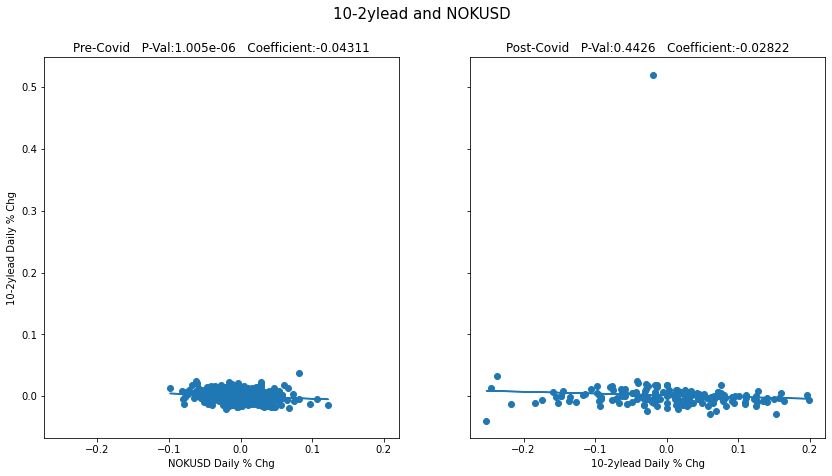

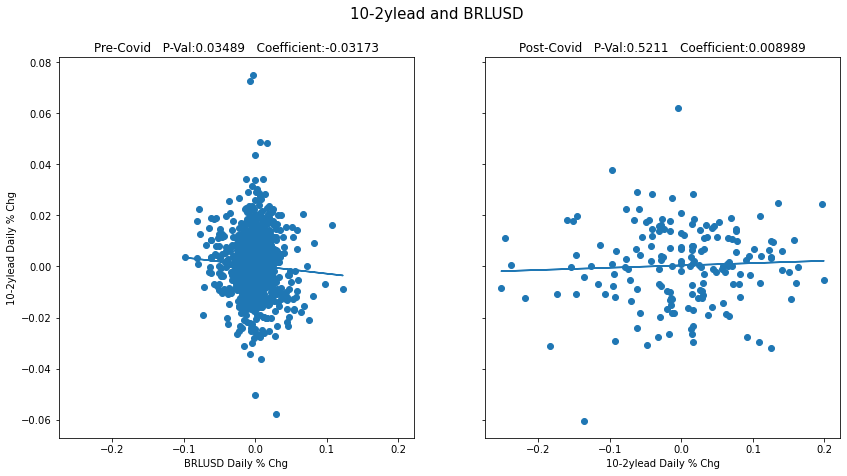

In [11]:
for item in pvaluespre2:
    x1 = xpre[item[0][0]]
    y1 = ypre[item[0][1]]
    x2 = xpost[item[0][0]]
    y2 = ypost[item[0][1]]
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,7), sharex=True, sharey=True)
    axes[0].scatter(x1, y1)
    axes[0].set_title(f'Pre-Covid   P-Val:{item[1]:.4}   Coefficient:{item[2]:.4}')
    axes[0].set_ylabel(f'{item[0][0]} Daily % Chg')
    axes[0].set_xlabel(f'{item[0][1]} Daily % Chg')
    axes[1].set_title(f'Post-Covid   P-Val:{item[3][0]:.4}   Coefficient:{item[3][1]:.4}')
    plt.xlabel(f'{item[0][0]} Daily % Chg')
    if item[1] < 0.05:
        m, b = np.polyfit(x1, y1, 1)
        axes[0].plot(x1, m*x1 + b)
    m2,b2 = np.polyfit(x2, y2, 1)
    axes[1].plot(x2, m2*x2 + b2)
    plt.suptitle(f'{item[0][0]} and {item[0][1]}',fontsize=15)
    axes[1].scatter(x2, y2)
    fig.show()